# Flatiron Health mPC: Data Wrangling Training Set

**OBJECTIVE: Identify a training cohort and create a dataframe of relevant variables which can be used to build machine learning survival models.**

**BACKGROUND: There are three sections to this notebook. First, the final cohort will be split 80-20 into a train and test set. The split will ensure the distribution of diagnosis years is the same in the train and test set given increased missingness of in earlier diagnosis years and changes in treatment practices with time. Of note, the 90-day-gap rule is not applied per Flatiron's new recommendations.**

**The second section of this notebook involves preparing the data so that each row corresponds to a unique patient from the train set and each column is a relevant variable for mortality prognositication. There are 12 CSV files from Flatiron that will be used. The eligibility window for collecting variables is typically -90 days and +30 days from index date, which is time of metastatic diagnosis. Plus 30 was selected as the upper bound of the eligibility window given that median time to start of first line treatment is about 30 days from metastatic diagnosis.**

**The last section involves merging these datatables into a master which will be used for building machine learning survival models.** 

**OUTLINE:**
1. **Creating training and test cohort**
2. **File cleaning for patients in training set**
3. **Merge files to create master training dataframe**

## Part 1: Creating training and test cohort 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

**Patients will be split into a train and test set (80/20) stratified by metastatic diagnosis year.**

In [3]:
enhanced_met = pd.read_csv('Enhanced_MetProstate.csv')

In [4]:
row_ID(enhanced_met)

(18927, 18927)

In [5]:
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

In [6]:
enhanced_met = enhanced_met.rename(columns = {'MetDiagnosisDate': 'met_date'})

In [7]:
enhanced_met['met_date'].dt.year.value_counts()/len(enhanced_met)

2019    0.119459
2018    0.111798
2016    0.111428
2017    0.106937
2020    0.105405
2015    0.104982
2021    0.100386
2014    0.097374
2013    0.090347
2022    0.051884
Name: met_date, dtype: float64

In [8]:
enhanced_met['met_date'].dt.year.describe()

count    18927.000000
mean      2017.352988
std          2.677797
min       2013.000000
25%       2015.000000
50%       2017.000000
75%       2020.000000
max       2022.000000
Name: met_date, dtype: float64

<AxesSubplot:xlabel='met_date'>

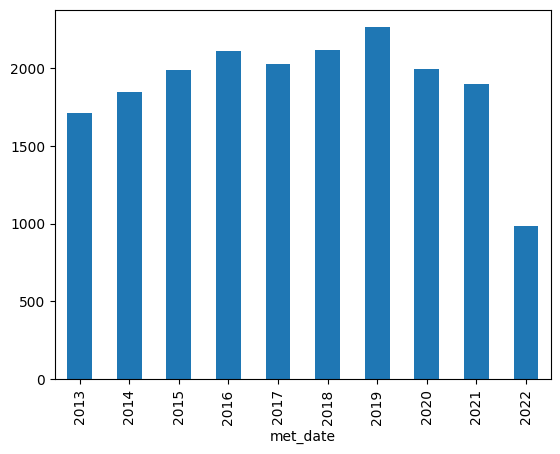

In [9]:
enhanced_met.groupby([enhanced_met['met_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='met_date'>

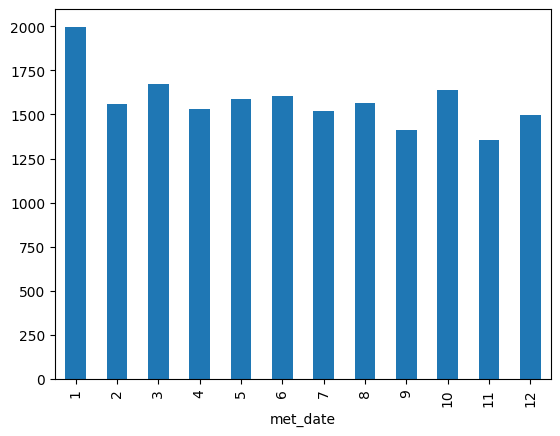

In [10]:
enhanced_met.groupby([enhanced_met['met_date'].dt.month])['PatientID'].count().plot(kind = 'bar')

In [11]:
enhanced_met['met_year_cat'] = pd.cut(enhanced_met['met_date'].dt.year,
                                      bins = [2012, 2014, 2016, 2018, 2020, 2022],
                                      labels = ['13-14', '15-16', '17-18', '19-20', '21-22'])

In [12]:
enhanced_met['met_year_cat'].value_counts(normalize = True, dropna = False)

19-20    0.224864
17-18    0.218735
15-16    0.216410
13-14    0.187721
21-22    0.152269
Name: met_year_cat, dtype: float64

In [13]:
enhanced_met['met_year_cat'].value_counts().sum()

18927

<AxesSubplot:xlabel='met_year_cat'>

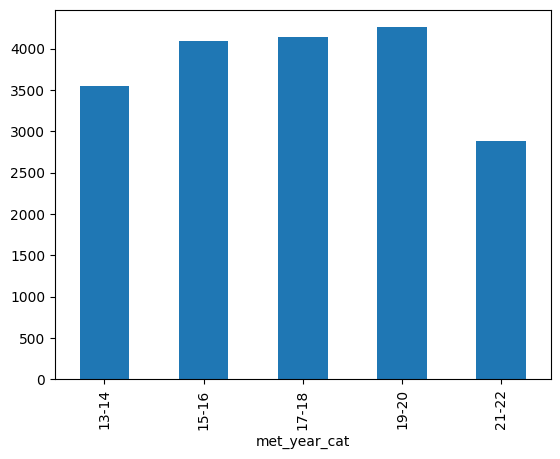

In [14]:
enhanced_met.groupby([enhanced_met['met_year_cat']])['PatientID'].count().plot(kind = 'bar')

In [15]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in sss.split(enhanced_met, enhanced_met['met_year_cat']):
    train_set = enhanced_met.iloc[train_index]
    test_set = enhanced_met.iloc[test_index]

In [16]:
train_set['met_year_cat'].value_counts()/len(train_set)

19-20    0.224886
17-18    0.218744
15-16    0.216432
13-14    0.187702
21-22    0.152236
Name: met_year_cat, dtype: float64

In [17]:
test_set['met_year_cat'].value_counts()/len(test_set)

19-20    0.224775
17-18    0.218700
15-16    0.216323
13-14    0.187797
21-22    0.152404
Name: met_year_cat, dtype: float64

In [18]:
row_ID(train_set)

(15141, 15141)

In [19]:
row_ID(test_set)

(3786, 3786)

In [20]:
# Array of PatientIDs in training set.
train_IDs = train_set['PatientID'].to_numpy()

In [21]:
pd.DataFrame(train_IDs, columns = ['PatientID']).to_csv('train_IDs.csv', index = False, header = True)

In [22]:
# Array of PatientIDs in test set.
test_IDs = test_set['PatientID'].to_numpy()

In [23]:
pd.DataFrame(test_IDs, columns = ['PatientID']).to_csv('test_IDs.csv', index = False, header = True)

In [24]:
%whos DataFrame

Variable       Type         Data/Info
-------------------------------------
enhanced_met   DataFrame               PatientID Diag<...>[18927 rows x 14 columns]
test_set       DataFrame               PatientID Diag<...>n[3786 rows x 14 columns]
train_set      DataFrame               PatientID Diag<...>[15141 rows x 14 columns]


In [25]:
# Keep enhanced_met
del test_set
del train_set

## Part 2: Data wrangling

**Relevant CSV files will be imported and processed. A file is considered processed when each row corresponds to a unique patient from the training set and each column is a relevant variable for mortality prognositication. The eligibility window for collecting variables is typically defined as -90 days and +30 days from index date. The index date is time of metastatic diagnosis. Plus 30 was selected as the upper bound of the eligibility window given that median time to start of first line treatment is about 30 days from metastatic diagnosis.** 

**The following CSV files from Flatiron will be cleaned:**
1. **Demographics and Practice**
2. **Enhanced_MetProstate**
3. **Enhanced_Mortality_V2**
4. **MedicationAdministration**
5. **Enhanced_MetPC_Biomarkers**
6. **Insurance**
7. **ECOG**
8. **Vitals**
9. **Labs**
10. **Diagnosis**
11. **Enhanced_MetPC_PrimaryTreatment**

### 1. Demographics

In [26]:
demographics = pd.read_csv('Demographics.csv')

In [27]:
demographics = demographics[demographics['PatientID'].isin(train_IDs)]

In [28]:
demographics.sample(5)

,PatientID,BirthYear,Gender,RaceSupplementedWithEthnicity,RaceEthnicitySource
10389,FD743E9DC6A31,1937,M,White,Race
17823,F4356498234EA,1937,M,White,Race
3134,FDAF5B0BBCE3D,1947,M,Other Race,Race
10380,F264C9770AAC3,1941,M,Other Race,Race
10929,FCB624666AA3F,1937,M,White,Race


In [29]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15141 entries, 0 to 18926
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   PatientID                      15141 non-null  object
 1   BirthYear                      15141 non-null  int64 
 2   Gender                         15141 non-null  object
 3   RaceSupplementedWithEthnicity  13936 non-null  object
 4   RaceEthnicitySource            15141 non-null  object
dtypes: int64(1), object(4)
memory usage: 709.7+ KB


In [30]:
row_ID(demographics)

(15141, 15141)

#### Race and Ethnicity

In [31]:
demographics['RaceSupplementedWithEthnicity'].value_counts(normalize = True, dropna = False)*100

White                        61.449046
Other Race                   15.983092
Black or African American    10.111617
NaN                           7.958523
Not Hispanic or Latino        2.298395
Asian                         1.294498
Hispanic or Latino            0.904828
Name: RaceSupplementedWithEthnicity, dtype: float64

In [32]:
demographics['RaceEthnicitySource'].value_counts(normalize = True, dropna = False)*100

Race         88.950532
Ethnicity    11.049468
Name: RaceEthnicitySource, dtype: float64

In [33]:
demographics.query('RaceSupplementedWithEthnicity == "Hispanic or Latino"').sample(5)

,PatientID,BirthYear,Gender,RaceSupplementedWithEthnicity,RaceEthnicitySource
1389,F1638CF3404D7,1948,M,Hispanic or Latino,Ethnicity
12812,F37C7C6DC2359,1950,M,Hispanic or Latino,Ethnicity
5671,F70C38AE90AEC,1952,M,Hispanic or Latino,Ethnicity
18469,F3D1C082575C8,1953,M,Hispanic or Latino,Ethnicity
7724,F6D1F4EB1E0AF,1943,M,Hispanic or Latino,Ethnicity


In [34]:
demographics.query('RaceSupplementedWithEthnicity == "Not Hispanic or Latino"').sample(5)

,PatientID,BirthYear,Gender,RaceSupplementedWithEthnicity,RaceEthnicitySource
4294,F08FD404E3331,1938,M,Not Hispanic or Latino,Ethnicity
7673,F5C25F6CA99F1,1937,M,Not Hispanic or Latino,Ethnicity
965,FE86CC60126F3,1939,M,Not Hispanic or Latino,Ethnicity
10504,FB1303E0B62F2,1938,M,Not Hispanic or Latino,Ethnicity
10593,F5FA5B67B772A,1937,M,Not Hispanic or Latino,Ethnicity


**There are unexpected values where “Hispanic or Latino” appears as a race rather than ethnicity. Ethnicity will be recoded to align with the FDA standards for collecting race and ethnicity variables for clinical trials. Possible race values will include: 'White', 'Other Race', 'Black or African American', 'Asian', or 'unknown'. Ethnicity values will be: 'Hispanic or Latino', 'Not Hispanic or Latino', or 'unknown'. Of note, ethnicity and race information is likely to be poorly captured since EHR platforms typically do not require documentation of race or ethnicity.**  

In [35]:
conditions = [
    (demographics['RaceSupplementedWithEthnicity'] == 'White'),
    (demographics['RaceSupplementedWithEthnicity'] == 'Other Race'),
    (demographics['RaceSupplementedWithEthnicity'] == 'Black or African American'),
    (demographics['RaceSupplementedWithEthnicity'] == 'Asian')]

choices = ['white', 'other', 'black', 'asian']

demographics.loc[:, 'race'] = np.select(conditions, choices, default = 'unknown')

In [36]:
demographics.race.value_counts(normalize = True, dropna = False)

white      0.614490
other      0.159831
unknown    0.111617
black      0.101116
asian      0.012945
Name: race, dtype: float64

In [37]:
conditions = [
    (demographics['RaceSupplementedWithEthnicity'] == 'Hispanic or Latino'),
    (demographics['RaceSupplementedWithEthnicity'] == 'Not Hispanic or Latino')]

choices = ['hispanic_latino', 'not_hispanic_latino']

demographics.loc[:, 'ethnicity'] = np.select(conditions, choices, default = 'unknown')

In [38]:
demographics.ethnicity.value_counts(normalize = True, dropna = False)

unknown                0.967968
not_hispanic_latino    0.022984
hispanic_latino        0.009048
Name: ethnicity, dtype: float64

In [39]:
demographics = demographics.drop(columns = ['RaceSupplementedWithEthnicity', 'RaceEthnicitySource'])

#### BirthYear

In [40]:
demographics['BirthYear'].describe()

count    15141.000000
mean      1945.410013
std          8.288445
min       1937.000000
25%       1937.000000
50%       1944.000000
75%       1951.000000
max       1980.000000
Name: BirthYear, dtype: float64

array([[<AxesSubplot:title={'center':'BirthYear'}>]], dtype=object)

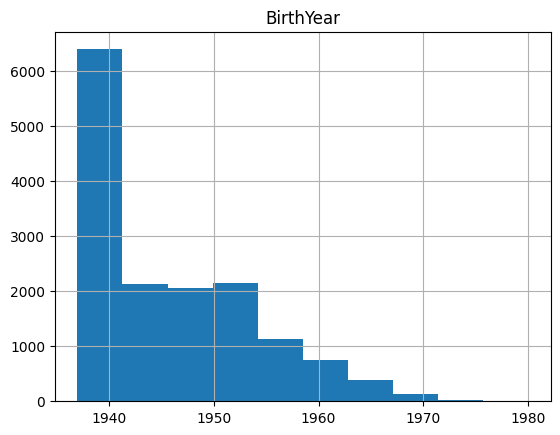

In [41]:
demographics.hist(column = 'BirthYear')

In [42]:
# Top 10 birth years.
demographics['BirthYear'].value_counts(normalize = True, dropna = False).head(10)

1937    0.285450
1943    0.038769
1942    0.037250
1938    0.035136
1947    0.035004
1946    0.034806
1941    0.034674
1940    0.034608
1949    0.033485
1944    0.033023
Name: BirthYear, dtype: float64

**Dispraportionate number of patients aged 85. Flatiron aggregates patients 85 and older into a single category of 85 years of age to limit potential for re-identification of older patients.**

In [43]:
demographics = pd.merge(demographics, enhanced_met[['PatientID', 'met_date']], on = 'PatientID')

In [44]:
demographics.loc[:, 'age'] = demographics['met_date'].dt.year - demographics['BirthYear']

In [45]:
demographics = demographics.drop(columns = ['BirthYear', 'met_date'])

#### PracticeType

In [46]:
practice = pd.read_csv('Practice.csv')

In [47]:
practice.sample(5)

,PatientID,PracticeType
8054,FC85BFD922CA6,COMMUNITY
18357,F2A4D495CF5ED,COMMUNITY
3100,FFA24024F1E6A,COMMUNITY
6513,F4E4860C2B54E,COMMUNITY
7458,FD32AD7593F39,ACADEMIC


In [48]:
practice = practice[practice['PatientID'].isin(train_IDs)]

In [49]:
row_ID(practice)

(15594, 15141)

In [50]:
practice.PracticeType.value_counts()

COMMUNITY    13363
ACADEMIC      2231
Name: PracticeType, dtype: int64

In [51]:
practice_unique_count = (
    practice.groupby('PatientID')['PracticeType'].agg('nunique')
    .to_frame()
    .reset_index()
    .rename(columns = {'PracticeType': 'n_type'})
)

In [52]:
practice_n = pd.merge(practice, practice_unique_count, on = 'PatientID')

In [53]:
practice_n['p_type'] = (
    np.where(practice_n['n_type'] == 1, practice_n['PracticeType'], 'BOTH')
)

In [54]:
practice_n = (
    practice_n.drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'p_type'])
)

In [55]:
demographics = pd.merge(demographics, practice_n, on = 'PatientID')

In [56]:
demographics['p_type'].value_counts(normalize = True, dropna = False)*100

COMMUNITY    85.284988
ACADEMIC     12.931775
BOTH          1.783238
Name: p_type, dtype: float64

#### Gender

In [57]:
demographics['Gender'].value_counts(normalize = True, dropna = False)*100

M    100.0
Name: Gender, dtype: float64

In [58]:
# Final training demographics table.
demographics.sample(5)

,PatientID,Gender,race,ethnicity,age,p_type
1683,F5D97538FB8F3,M,white,unknown,60,COMMUNITY
31,F85800BF8202F,M,unknown,unknown,80,COMMUNITY
13069,FF0EE14B94E4B,M,unknown,unknown,73,COMMUNITY
10157,F88210D594D48,M,other,unknown,63,ACADEMIC
8927,F35227B837AAB,M,asian,unknown,67,COMMUNITY


In [59]:
%whos DataFrame

Variable                Type         Data/Info
----------------------------------------------
demographics            DataFrame               PatientID Gend<...>n[15141 rows x 6 columns]
enhanced_met            DataFrame               PatientID Diag<...>[18927 rows x 14 columns]
practice                DataFrame               PatientID Prac<...>n[15594 rows x 2 columns]
practice_n              DataFrame               PatientID     <...>n[15141 rows x 2 columns]
practice_unique_count   DataFrame               PatientID  n_t<...>n[15141 rows x 2 columns]


In [60]:
# Keep demographics and enhanced_met
del practice
del practice_n
del practice_unique_count

### 2. Enhanced_MetProstate

In [61]:
enhanced_met.sample(5)

,PatientID,DiagnosisDate,met_date,GroupStage,TStage,NStage,MStage,Histology,IsCRPC,CRPCDate,GleasonScore,PSADiagnosis,PSAMetDiagnosis,met_year_cat
16048,F928F95BBA130,1996-11-27,2013-04-11,Unknown / Not documented,Unknown / Not documented,Unknown / Not documented,Unknown / Not documented,Adenocarcinoma,No,NaN,3 + 4 = 7,NaN,0.98,13-14
1331,FDF411F6C0D05,2009-11-02,2015-10-01,Unknown / Not documented,Unknown / Not documented,Unknown / Not documented,M0,Adenocarcinoma,Yes,2015-12-30,9,27.7,76.50,15-16
7164,F6D21D2E0630F,2008-02-14,2015-08-15,Unknown / Not documented,Unknown / Not documented,Unknown / Not documented,Unknown / Not documented,"Prostate cancer, NOS",No,NaN,Unknown / Not documented,NaN,1.70,15-16
15597,F416FB7B8B59D,2001-12-01,2015-03-26,IV,TX,NX,M0,Adenocarcinoma,No,NaN,Less than or equal to 6,6.8,0.71,15-16
14531,F7DD82C44916F,2007-04-25,2015-03-27,Unknown / Not documented,T2c,N0,M0,Adenocarcinoma,Yes,2015-03-24,8,22.0,28.00,15-16


In [62]:
enhanced_met.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18927 entries, 0 to 18926
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   PatientID        18927 non-null  object        
 1   DiagnosisDate    18668 non-null  object        
 2   met_date         18927 non-null  datetime64[ns]
 3   GroupStage       18927 non-null  object        
 4   TStage           18927 non-null  object        
 5   NStage           18927 non-null  object        
 6   MStage           18927 non-null  object        
 7   Histology        18927 non-null  object        
 8   IsCRPC           18927 non-null  object        
 9   CRPCDate         11708 non-null  object        
 10  GleasonScore     18927 non-null  object        
 11  PSADiagnosis     13463 non-null  float64       
 12  PSAMetDiagnosis  16184 non-null  float64       
 13  met_year_cat     18927 non-null  category      
dtypes: category(1), datetime64[ns](1), flo

In [63]:
enhanced_met = enhanced_met[enhanced_met['PatientID'].isin(train_IDs)]

In [64]:
row_ID(enhanced_met)

(15141, 15141)

#### GroupStage 

In [65]:
enhanced_met.GroupStage.value_counts(dropna = False, normalize = True)

Unknown / Not documented    0.397002
IV                          0.284592
IVB                         0.203553
III                         0.030975
IIB                         0.024833
II                          0.016710
IIA                         0.012086
IVA                         0.007859
I                           0.007727
IIIC                        0.006340
IIIB                        0.004293
IIC                         0.002774
IIIA                        0.001255
Name: GroupStage, dtype: float64

In [66]:
# Dictionary for regrouping stages
stage_dict = { 
    'I': 'I',
    'II': 'II',
    'IIA': 'II',
    'IIB': 'II',
    'IIC': 'II',
    'III': 'III',
    'IIIA': 'III',
    'IIIB': 'III',
    'IIIC': 'III',
    'IV': 'IV',
    'IVA': 'IV',
    'IVB': 'IV',
    'Unknown / Not documented': 'unknown'
}

enhanced_met['stage'] = enhanced_met['GroupStage'].map(stage_dict)

In [67]:
enhanced_met['stage'].value_counts(normalize = True, dropna = False)

IV         0.496004
unknown    0.397002
II         0.056403
III        0.042864
I          0.007727
Name: stage, dtype: float64

In [68]:
enhanced_met = enhanced_met.drop(columns = ['GroupStage'])

#### TStage

In [69]:
enhanced_met.TStage.value_counts(normalize = True, dropna = False)

Unknown / Not documented    0.542633
T1c                         0.074037
T2c                         0.072584
T3b                         0.068093
T3a                         0.052440
TX                          0.044779
T2                          0.030315
T4                          0.028532
T2b                         0.027607
T3                          0.025428
T2a                         0.024107
T1b                         0.003699
T1                          0.003236
T1a                         0.001783
T0                          0.000727
Name: TStage, dtype: float64

In [70]:
enhanced_met = enhanced_met.drop(columns = ['TStage'])

#### NStage

In [71]:
enhanced_met.NStage.value_counts(normalize = True, dropna = False)

Unknown / Not documented    0.557493
N0                          0.228519
N1                          0.149924
NX                          0.064064
Name: NStage, dtype: float64

#### MStage

In [72]:
enhanced_met.MStage.value_counts(normalize = True, dropna = False)

M0                          0.347269
M1                          0.330361
Unknown / Not documented    0.197213
M1b                         0.084341
M1c                         0.028994
M1a                         0.011822
Name: MStage, dtype: float64

#### Histology

In [73]:
enhanced_met.Histology.value_counts(normalize = True, dropna = False)

Adenocarcinoma          0.818638
Prostate cancer, NOS    0.181362
Name: Histology, dtype: float64

#### GleasonScore

In [74]:
enhanced_met.GleasonScore.value_counts(normalize = True, dropna = False)

Unknown / Not documented            0.278713
9                                   0.264712
8                                   0.152632
4 + 3 = 7                           0.087973
3 + 4 = 7                           0.073245
Less than or equal to 6             0.062017
10                                  0.058847
7 (when breakdown not available)    0.021861
Name: GleasonScore, dtype: float64

#### MetDiagnosisDate

In [75]:
enhanced_met['met_date'].min()

Timestamp('2013-01-01 00:00:00')

In [76]:
enhanced_met['met_date'].max()

Timestamp('2022-09-30 00:00:00')

In [77]:
enhanced_met['met_date'].dt.year.describe()

count    15141.000000
mean      2017.352619
std          2.680035
min       2013.000000
25%       2015.000000
50%       2017.000000
75%       2020.000000
max       2022.000000
Name: met_date, dtype: float64

In [78]:
enhanced_met.loc[:, 'met_year'] = enhanced_met['met_date'].dt.year

#### DiagnosisDate

In [79]:
enhanced_met['DiagnosisDate'].isna().sum()

206

In [80]:
enhanced_met = enhanced_met.rename(columns = {'DiagnosisDate': 'diagnosis_date'})

In [81]:
# Missing diagnosis_date will be replaced with met_date; other dates will be left untouched. 
enhanced_met['diagnosis_date'] = (
    np.where(enhanced_met['diagnosis_date'].isna(), enhanced_met['met_date'], enhanced_met['diagnosis_date'])
)

In [82]:
enhanced_met['diagnosis_date'] = pd.to_datetime(enhanced_met['diagnosis_date'])

In [83]:
enhanced_met['diagnosis_date'].min()

Timestamp('1970-01-01 00:00:00')

In [84]:
enhanced_met['diagnosis_date'].max()

Timestamp('2022-09-29 00:00:00')

In [85]:
enhanced_met['diagnosis_date'].dt.year.describe()

count    15141.000000
mean      2012.745856
std          7.091309
min       1970.000000
25%       2009.000000
50%       2015.000000
75%       2018.000000
max       2022.000000
Name: diagnosis_date, dtype: float64

<AxesSubplot:xlabel='diagnosis_date'>

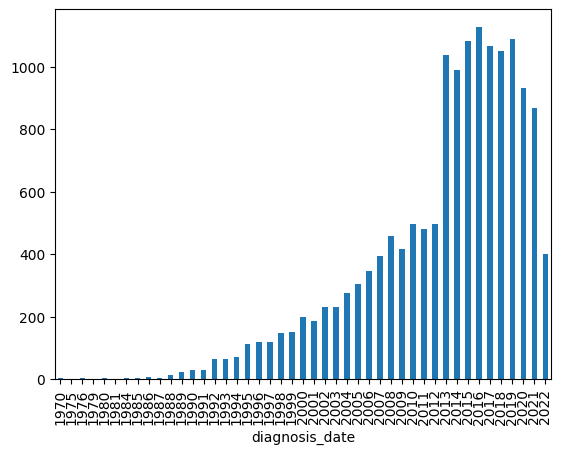

In [86]:
# Bar plot of number of new CRC diagnoses per year.
enhanced_met.groupby([enhanced_met['diagnosis_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

**The range of dates for diagnosis is 1/1970 to 9/2022 with a median year of 2015.** 

In [87]:
# Percent of patients diagnosed prior to metastatic diagnosis. 
(
    enhanced_met
    .query('diagnosis_date < met_date')
    .shape[0]/(len(enhanced_met))
)

0.5308103824053894

#### Time from diagnosis date to metastatic date

In [88]:
enhanced_met.loc[:, 'delta_met_diagnosis'] = (enhanced_met['met_date'] - enhanced_met['diagnosis_date']).dt.days

In [89]:
# Brief summary statistics on time between diagnosis date and metastatic diagnosis.
(
    enhanced_met[['met_year', 'delta_met_diagnosis']]
    .query('delta_met_diagnosis > 0')
    .describe()
)

,met_year,delta_met_diagnosis
count,8037.000000,8037.000000
mean,2017.149683,3214.050268
std,2.680352,2409.455043
min,2013.000000,24.000000
25%,2015.000000,1277.000000
50%,2017.000000,2667.000000
75%,2019.000000,4665.000000
max,2022.000000,18993.000000


#### CRPC

In [90]:
enhanced_met.IsCRPC.value_counts(normalize = True, dropna = False)

Yes    0.631332
No     0.368668
Name: IsCRPC, dtype: float64

In [91]:
enhanced_met['CRPCDate'] = pd.to_datetime(enhanced_met['CRPCDate'])

In [92]:
# Make CRPC true if date of CRPC is <= +30 days from metastatic diagnosis date. 
enhanced_met['crpc'] = (
    np.where(((enhanced_met['CRPCDate'] - enhanced_met['met_date']).dt.days <= 30), 1, 0)
)

In [93]:
enhanced_met.query('crpc == 1').sample(5)

,PatientID,diagnosis_date,met_date,NStage,MStage,Histology,IsCRPC,CRPCDate,GleasonScore,PSADiagnosis,PSAMetDiagnosis,met_year_cat,stage,met_year,delta_met_diagnosis,crpc
5048,F738721A49578,1997-01-01,2016-07-25,Unknown / Not documented,Unknown / Not documented,"Prostate cancer, NOS",Yes,2016-07-01,Unknown / Not documented,NaN,83.00,15-16,unknown,2016,7145,1
11044,F5061DDE9B84B,2013-01-01,2014-11-05,Unknown / Not documented,Unknown / Not documented,"Prostate cancer, NOS",Yes,2014-12-01,9,900.0,466.00,13-14,unknown,2014,673,1
13424,F3CAE8A87B344,1999-01-01,2020-10-07,Unknown / Not documented,M0,"Prostate cancer, NOS",Yes,2019-12-01,Unknown / Not documented,NaN,6.37,19-20,unknown,2020,7950,1
17761,FF2CBFCDB5084,2000-11-01,2019-09-05,Unknown / Not documented,Unknown / Not documented,Adenocarcinoma,Yes,2013-01-01,4 + 3 = 7,NaN,NaN,19-20,unknown,2019,6882,1
12867,FAE4C38D682CC,1998-12-09,2014-08-05,Unknown / Not documented,Unknown / Not documented,Adenocarcinoma,Yes,2014-08-12,Less than or equal to 6,10.2,NaN,13-14,unknown,2014,5718,1


In [94]:
enhanced_met['crpc_time'] = (
    np.where(enhanced_met['crpc'] == 1, (enhanced_met['CRPCDate'] - enhanced_met['diagnosis_date']).dt.days, 0)
)

In [95]:
enhanced_met[['crpc_time']].query('crpc_time > 0').describe()

,crpc_time
count,2922.000000
mean,3098.898700
std,2359.607669
min,2.000000
25%,1114.000000
50%,2561.500000
75%,4625.000000
max,14137.000000


In [96]:
enhanced_met.crpc.value_counts()

0    12193
1     2948
Name: crpc, dtype: int64

In [97]:
enhanced_met.IsCRPC.value_counts()

Yes    9559
No     5582
Name: IsCRPC, dtype: int64

In [98]:
# Keep CRPCDate for mortality section.
enhanced_met = enhanced_met.drop(columns = ['IsCRPC'])

#### PSA 

In [99]:
enhanced_met['PSADiagnosis'].isna().sum()

4385

In [100]:
enhanced_met['PSAMetDiagnosis'].isna().sum()

2201

In [101]:
enhanced_met[['PSADiagnosis', 'PSAMetDiagnosis']].describe()

,PSADiagnosis,PSAMetDiagnosis
count,10756.000000,12940.000000
mean,359.737904,354.208365
std,1963.667328,1819.321581
min,0.000000,0.000000
25%,9.800000,11.000000
50%,35.000000,44.500000
75%,191.375000,207.250000
max,127000.000000,127000.000000


In [102]:
enhanced_met['psa_diag_na'] = (
    np.where(enhanced_met['PSADiagnosis'].isna(), 1, 0)
)

In [103]:
enhanced_met['psa_met_na'] = (
    np.where(enhanced_met['PSAMetDiagnosis'].isna(), 1, 0)
)

In [104]:
# Final enhanced_met dataframe
enhanced_met.sample(5)

,PatientID,diagnosis_date,met_date,NStage,MStage,Histology,CRPCDate,GleasonScore,PSADiagnosis,PSAMetDiagnosis,met_year_cat,stage,met_year,delta_met_diagnosis,crpc,crpc_time,psa_diag_na,psa_met_na
14484,F7AE330A1A02E,2002-11-14,2015-06-26,Unknown / Not documented,Unknown / Not documented,Adenocarcinoma,2015-03-12,Less than or equal to 6,4.30,5.34,15-16,unknown,2015,4607,1,4501.0,0,0
14464,F1F1CB1D63254,2019-06-24,2019-06-24,Unknown / Not documented,M1,"Prostate cancer, NOS",2019-11-08,Unknown / Not documented,828.00,828.00,19-20,IV,2019,0,0,0.0,0,0
5420,F63099D77E807,2019-07-02,2019-07-02,Unknown / Not documented,M1,Adenocarcinoma,2020-01-01,8,NaN,NaN,19-20,IV,2019,0,0,0.0,1,1
16990,F9B215F6EB708,2021-08-10,2021-08-10,Unknown / Not documented,M1,Adenocarcinoma,2022-03-02,Unknown / Not documented,122.11,122.11,21-22,IV,2021,0,0,0.0,0,0
18153,F5F9AF1EE23D9,2019-05-28,2019-05-28,N1,M1,Adenocarcinoma,2020-01-29,9,361.30,361.30,19-20,IV,2019,0,0,0.0,0,0


In [105]:
# Keep demographics and enhanced_met. 
%whos DataFrame

Variable       Type         Data/Info
-------------------------------------
demographics   DataFrame               PatientID Gend<...>n[15141 rows x 6 columns]
enhanced_met   DataFrame               PatientID diag<...>[15141 rows x 18 columns]


### 3. Enhanced_Mortality_V2

In [106]:
mortality = pd.read_csv('Enhanced_Mortality_V2.csv')

In [107]:
mortality = mortality[mortality['PatientID'].isin(train_IDs)]

In [108]:
mortality.sample(5)

,PatientID,DateOfDeath
5558,FCE384CAE6136,2017-11-13
9461,F3621B53714CA,2019-02-22
3057,FF58553F36F4F,2014-12-03
9365,FE3F164E7C3E8,2018-10-21
6260,F345AB8EDDD38,2019-08-21


In [109]:
mortality.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7854 entries, 0 to 9810
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PatientID    7854 non-null   object
 1   DateOfDeath  7854 non-null   object
dtypes: object(2)
memory usage: 184.1+ KB


In [110]:
row_ID(mortality)

(7854, 7854)

In [111]:
mortality = mortality.rename(columns = {'DateOfDeath': 'death_date'})

In [112]:
# Patients with year granularity.
mortality[mortality['death_date'].str.len() == 4]

,PatientID,death_date
5,F116F9597F7D3,2020
1018,FA84019AC51A2,2016
3509,F973AC7AB1862,2020
3968,F68D949A4FA89,2015
8493,F19E8A1B3B08E,2019
9241,FC9C9FC3C8C45,2022


**The date of death is generalized to the month for de-identification purposes, however, a small number of patients have just the year for date of death. For analyses requiring a day of death, Flatiron Health recommends imputing the 15th of the month since this approach best approximates the results generated from using the exact date of death. For those with a date of death with year granularity, Flatiron recommends imputing the middle of the year and conducting a sensitivty analysis to evaluate assumption.**

In [113]:
# For patients with year granularity, impute middle of the year (ie., July 1)
mortality['death_date'] = (
    np.where(mortality['death_date'].str.len() == 4, mortality['death_date'] + '-07-01', mortality['death_date'])
)

In [114]:
# For patients with month granularity, impute 15th of the month.
mortality['death_date'] = (
    np.where(mortality['death_date'].str.len() == 7, mortality['death_date'] + '-15', mortality['death_date'])
)

In [115]:
mortality['death_date'] = pd.to_datetime(mortality['death_date'])

In [116]:
# Percent of patients with death date.  
len(mortality)/len(train_IDs)

0.5187239944521498

<AxesSubplot:xlabel='death_date'>

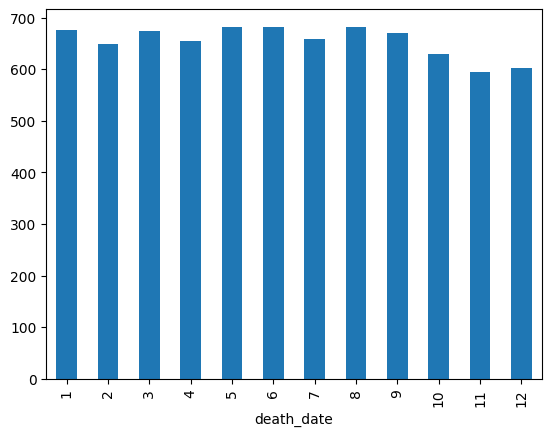

In [117]:
# Bar plot of monthly mortality for aNSCLC. 
mortality.groupby([mortality['death_date'].dt.month])['PatientID'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='death_date'>

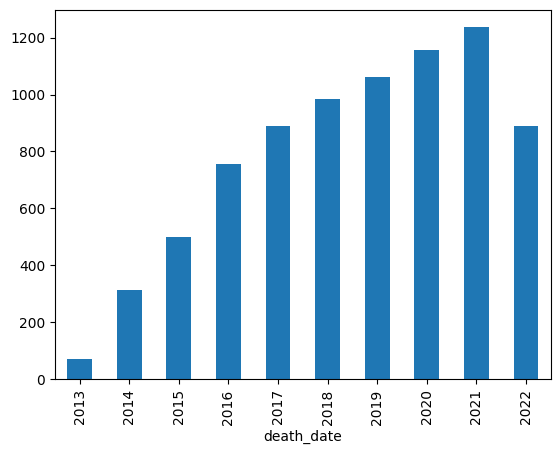

In [118]:
# Bar plot of yearly mortality for aNSCLC. 
mortality.groupby([mortality['death_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

#### Censoring

**For patients for whom a date of death is not known, the censor date can be defined either as the data cutoff date or as the last confirmed activity date. The last confirmed activity date is broadly defined as the last date at which there is evidence in the EHR that a patient is alive. Evidence of a record in at least one of the items listed below qualifies as patient-level confirmed activity:**
* **Visit: VisitDate**
* **Telemedicine: VisitDate**
* **Enhanced_MetPC_Orals: StartDate or EndDate**
* **Enhanced_MetPC_Biomarkers: SpecimenCollectedDate**
* **Enhanced_MetPC_ADT: StartDate or EndDate**
* **Enhanced_MetPC_AlphaBetaEmitters: AdministrationDate**
* **Enhanced_MetPC_PrimaryTreatment: TreatmentDate**
* **Enhanced_MetPC_Provenge: StartDate**
* **Enhanced_MetProstate: CRPCDate**

In [119]:
visit = pd.read_csv('Visit.csv')
telemedicine = pd.read_csv('Telemedicine.csv')
orals = pd.read_csv('Enhanced_MetPC_Orals.csv')
biomarkers = pd.read_csv('Enhanced_MetPC_Biomarkers.csv')
adt = pd.read_csv('Enhanced_MetPC_ADT.csv')
alpha_beta = pd.read_csv('Enhanced_MetPC_AlphaBetaEmitters.csv')
treat = pd.read_csv('Enhanced_MetPC_PrimaryTreatment.csv')
provenge = pd.read_csv('Enhanced_MetPC_Provenge.csv')

##### Visit and Telemedicine

In [120]:
visit.sample(5)

,PatientID,VisitDate,VisitType,IsVitalsVisit,IsTreatmentVisit,IsLabVisit
127499,FE86409E1E814,2017-12-09,Treatment,True,True,True
216978,F4565621287CC,2019-04-30,Treatment,True,True,False
661482,FE41263868850,2017-06-22,Treatment,False,True,False
566092,F69F22F93523F,2016-11-30,Treatment,True,True,True
412528,F5FDF9BEA3141,2020-07-14,Treatment,True,True,True


In [121]:
visit.shape

(744472, 6)

In [122]:
telemedicine.sample(5)

,PatientID,VisitDate
125,F1A558AE9AD0E,2020-04-20
1573,F1AE0E4D18B1E,2020-04-09
2261,F9F45A9DE9AAE,2021-05-10
5763,FB899AFA798FC,2020-03-30
2265,F9F45A9DE9AAE,2021-10-20


In [123]:
telemedicine.shape

(10830, 2)

In [124]:
visit_tele = (
    visit
    .drop(columns = ['VisitType', 'IsVitalsVisit', 'IsTreatmentVisit', 'IsLabVisit'])
    .append(telemedicine)
) 

In [125]:
visit_tele.shape

(755302, 2)

In [126]:
visit_tele.loc[:,'VisitDate'] = pd.to_datetime(visit_tele['VisitDate'])

In [127]:
visit_tele.sample(5)

,PatientID,VisitDate
676252,F658121BD557E,2019-09-23
581887,F64653FF1959C,2015-06-29
322712,FFFD421EB1A32,2013-03-28
504235,F60236CC4EEB4,2020-07-01
635143,F048B8E0EB967,2019-07-31


In [128]:
# Select max VisitDate from combined Visit and Telemedicine table.
visit_tele_max = (
    visit_tele
    [visit_tele['PatientID'].isin(train_IDs)]
    .groupby('PatientID')['VisitDate'].max()
    .to_frame(name = 'visit_max')
    .reset_index()
)

In [129]:
row_ID(visit_tele_max)

(15141, 15141)

##### Orals

In [130]:
orals = orals[orals['PatientID'].isin(train_IDs)]

In [131]:
orals.loc[:, 'StartDate'] = pd.to_datetime(orals['StartDate'])

In [132]:
orals.loc[:, 'EndDate'] = pd.to_datetime(orals['EndDate'])

In [133]:
orals_max = (
    orals
    .assign(max_date = orals[['StartDate', 'EndDate']].max(axis = 1))
    .groupby('PatientID')['max_date'].max()
    .to_frame(name = 'orals_max')
    .reset_index()
)

In [134]:
row_ID(orals_max)

(13539, 13539)

##### Biomarkers

In [135]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(train_IDs)]

In [136]:
biomarkers.loc[:, 'SpecimenCollectedDate'] = pd.to_datetime(biomarkers['SpecimenCollectedDate'])

In [137]:
biomarkers_max = (
    biomarkers
    .groupby('PatientID')['SpecimenCollectedDate'].max()
    .to_frame(name = 'biomarkers_max')
    .reset_index()
)

In [138]:
row_ID(biomarkers_max)

(4233, 4233)

##### ADT

In [139]:
adt = adt[adt['PatientID'].isin(train_IDs)]

In [140]:
row_ID(adt)

(16397, 14629)

In [141]:
adt.loc[:, 'StartDate'] = pd.to_datetime(adt['StartDate'])

In [142]:
adt.loc[:, 'EndDate'] = pd.to_datetime(adt['EndDate'])

In [143]:
adt_max = (
    adt
    .assign(max_date = adt[['StartDate', 'EndDate']].max(axis = 1))
    .groupby('PatientID')['max_date'].max()
    .to_frame(name = 'adt_max')
    .reset_index()
)

In [144]:
row_ID(adt_max)

(14629, 14629)

##### Alpha Beta Emitters

In [145]:
alpha_beta = alpha_beta[alpha_beta['PatientID'].isin(train_IDs)]

In [146]:
row_ID(alpha_beta)

(5792, 1377)

In [147]:
alpha_beta.loc[:, 'AdministrationDate'] = pd.to_datetime(alpha_beta['AdministrationDate'])

In [148]:
alpha_beta_max = (
    alpha_beta
    .groupby('PatientID')['AdministrationDate'].max()
    .to_frame(name = 'alpha_beta_max')
    .reset_index()
)

In [149]:
row_ID(alpha_beta_max)

(1377, 1377)

##### Primary Treatment 

In [150]:
treat = treat[treat['PatientID'].isin(train_IDs)]

In [151]:
row_ID(treat)

(6552, 6552)

In [152]:
treat.loc[:, 'TreatmentDate'] = pd.to_datetime(treat['TreatmentDate'])

In [153]:
treat_max = (
    treat
    .groupby('PatientID')['TreatmentDate'].max()
    .to_frame(name = 'treat_max')
    .reset_index()
)

In [154]:
row_ID(treat_max)

(6552, 6552)

##### Provenge

In [155]:
provenge = provenge[provenge['PatientID'].isin(train_IDs)]

In [156]:
row_ID(provenge)

(1266, 1266)

In [157]:
provenge.loc[:, 'StartDate'] = pd.to_datetime(provenge['StartDate'])

In [158]:
provenge_max = (
    provenge
    .groupby('PatientID')['StartDate'].max()
    .to_frame(name = 'provenge_max')
    .reset_index()
)

In [159]:
row_ID(provenge_max)

(1266, 1266)

##### CRPC Date

In [160]:
crpc_max = enhanced_met[enhanced_met['CRPCDate'].notna()][['PatientID', 'CRPCDate']]

In [161]:
row_ID(crpc_max)

(9405, 9405)

##### Max date merge

In [162]:
last_activity = pd.merge(visit_tele_max, orals_max, on = 'PatientID', how = 'outer')

In [163]:
last_activity = pd.merge(last_activity, biomarkers_max, on = 'PatientID', how = 'outer')

In [164]:
last_activity = pd.merge(last_activity, adt_max, on = 'PatientID', how = 'outer')

In [165]:
last_activity = pd.merge(last_activity, alpha_beta_max, on = 'PatientID', how = 'outer')

In [166]:
last_activity = pd.merge(last_activity, treat_max, on = 'PatientID', how = 'outer')

In [167]:
last_activity = pd.merge(last_activity, provenge_max, on = 'PatientID', how = 'outer')

In [168]:
last_activity = pd.merge(last_activity, crpc_max, on = 'PatientID', how = 'outer')

In [169]:
row_ID(last_activity)

(15141, 15141)

In [170]:
last_activity.sample(5)

,PatientID,visit_max,orals_max,biomarkers_max,adt_max,alpha_beta_max,treat_max,provenge_max,CRPCDate
9291,F9BE21D1FFE65,2018-02-28,2018-02-28,NaT,NaT,NaT,NaT,NaT,2017-09-07
10692,FB3E18726E743,2014-08-07,2014-05-16,NaT,2013-07-10,NaT,NaT,NaT,2014-03-07
11685,FC49BE3482942,2015-05-01,NaT,NaT,2010-01-01,NaT,2001-01-01,NaT,NaT
13772,FE86C7426E066,2020-04-27,2020-04-27,NaT,2016-08-24,NaT,NaT,NaT,2018-01-10
8862,F94DF55DA1941,2022-02-08,2022-02-08,2021-07-08,2021-07-01,NaT,NaT,NaT,NaT


In [171]:
# Find max of each row. 
last_activity = (
    last_activity
    .assign(last_activity = last_activity[['visit_max', 'orals_max', 'biomarkers_max', 'adt_max', 'alpha_beta_max', 'treat_max', 'provenge_max', 'CRPCDate']].max(axis = 1))
    .filter(items = ['PatientID', 'last_activity'])
)

In [172]:
len(last_activity) == len(train_IDs)

True

In [173]:
last_activity['last_activity'].isna().sum()

0

In [174]:
# Append missing training IDs.
mortality = (
    mortality
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(mortality['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False
    )
)

In [175]:
row_ID(mortality)

(15141, 15141)

In [176]:
mortality = pd.merge(mortality, enhanced_met[['PatientID', 'met_date']], on = 'PatientID')

In [177]:
mortality = pd.merge(mortality, last_activity, on = 'PatientID')

In [178]:
row_ID(mortality)

(15141, 15141)

In [179]:
mortality.sample(5)

,PatientID,death_date,met_date,last_activity
14849,FCA0398A9A827,NaT,2018-01-25,2022-09-29
6685,FE0957E771D7C,2021-07-09,2018-02-13,2021-06-01
6580,FC0F9E158FC12,2017-02-22,2013-10-04,2017-02-14
14922,F3BDE1393B566,NaT,2017-06-03,2017-06-07
5274,FB7AB1A928217,2017-03-08,2014-05-08,2017-01-25


In [180]:
mortality.loc[:, 'death_status'] = np.where(mortality['death_date'].isna(), 0, 1)

In [181]:
# timerisk_activity is time from metastatic diagnosis to death or last activity if no death date.
mortality.loc[:, 'timerisk_activity'] = (
    np.where(mortality['death_date'].isna(),
             (mortality['last_activity'] - mortality['met_date']).dt.days,
             (mortality['death_date'] - mortality['met_date']).dt.days)
)

In [182]:
# If timerisk_activity is less than 0, set to 0 otherwise remains unchanged. 
mortality['timerisk_activity'] = np.where(mortality['timerisk_activity'] < 0, 0, mortality['timerisk_activity'])

In [183]:
mortality.sample(5)

,PatientID,death_date,met_date,last_activity,death_status,timerisk_activity
8845,F11B7C1CF1B4F,NaT,2021-10-13,2022-09-28,0,350.0
9542,FC0B192001A39,NaT,2016-06-20,2018-01-30,0,589.0
1050,FF03E9D56F023,2020-04-23,2018-01-23,2019-05-07,1,821.0
13722,F2A593BD80AB8,NaT,2022-05-17,2022-09-09,0,115.0
3925,FF08D177584BF,2016-12-06,2016-03-21,2016-11-30,1,260.0


In [184]:
mortality.timerisk_activity.describe()

count    15141.000000
mean       923.884882
std        728.399957
min          0.000000
25%        358.000000
50%        732.000000
75%       1313.000000
max       3559.000000
Name: timerisk_activity, dtype: float64

In [185]:
# Percent of patients censored overall. 
(mortality.shape[0] - mortality['death_status'].sum())/mortality.shape[0]

0.4812760055478502

In [186]:
# Percent of patients dying within 365 days. 
((mortality['death_status'] == 1) & (mortality['timerisk_activity'] <= 365)).sum()/mortality.shape[0]

0.12515685886004888

In [187]:
# Percent of patients dying within 720 days. 
((mortality['death_status'] == 1) & (mortality['timerisk_activity'] <= 720)).sum()/mortality.shape[0]

0.2626642890165775

Median survival in days: 1208.0


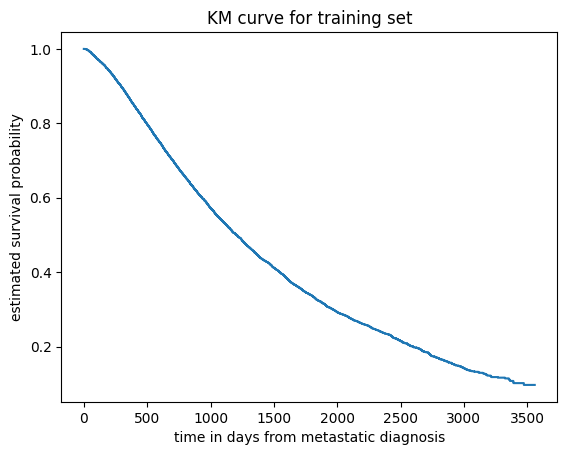

In [188]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

%matplotlib inline

time, survival_prob = kaplan_meier_estimator(mortality['death_status'].astype('bool'), mortality['timerisk_activity'])
plt.step(time, survival_prob, where = 'post')

plt.title('KM curve for training set')
plt.ylabel('estimated survival probability')
plt.xlabel('time in days from metastatic diagnosis')
print('Median survival in days:', time[np.where(survival_prob <0.5)][0])

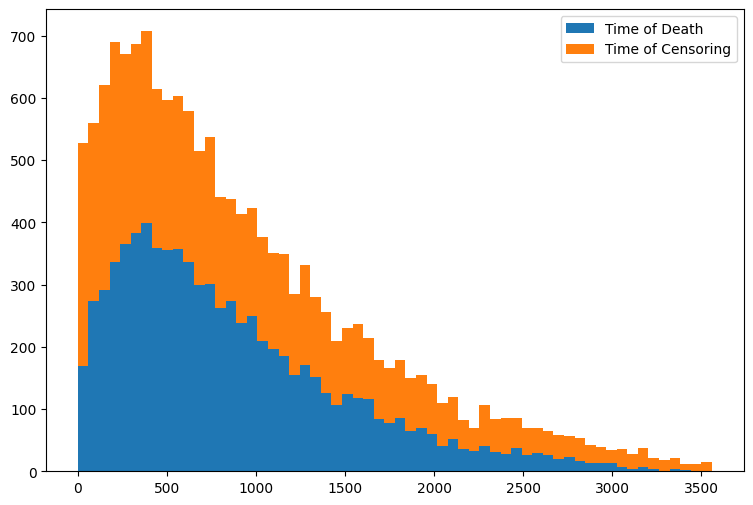

In [189]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((mortality['timerisk_activity'][mortality['death_status'].astype('bool')],
                               mortality['timerisk_activity'][~mortality['death_status'].astype('bool')]),
                              bins = 60, stacked = True)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

In [190]:
mortality = pd.merge(mortality, enhanced_met[['PatientID', 'diagnosis_date']], on = 'PatientID', how = 'outer')

In [191]:
# timerisk_activity_first is time from first diagnosis (metastatic or not) to death or last activity if no death date.
mortality.loc[:, 'timerisk_activity_first'] = (
    np.where(mortality['death_date'].isna(),
             (mortality['last_activity'] - mortality['diagnosis_date']).dt.days,
             (mortality['death_date'] - mortality['diagnosis_date']).dt.days)
)

In [192]:
# If timerisk_activity is less than 0, set to 0 otherwise remains unchanged. 
mortality['timerisk_activity_first'] = np.where(
    mortality['timerisk_activity_first'] < 0, 0, mortality['timerisk_activity_first'])

In [193]:
mortality.to_csv('mortality_cleaned_tr.csv', index = False, header = True)

In [194]:
mortality = mortality.filter(items = ['PatientID', 'death_status', 'timerisk_activity'])

In [195]:
mortality.sample(5)

,PatientID,death_status,timerisk_activity
4700,F0F760FC72C09,1,2326.0
1180,FD9CFDC991477,1,320.0
5223,F6F6487E45712,1,907.0
13133,F39DF309BE659,0,34.0
5458,F44F315F7D241,1,340.0


In [196]:
%whos DataFrame

Variable         Type         Data/Info
---------------------------------------
adt              DataFrame               PatientID Trea<...>n[16397 rows x 5 columns]
adt_max          DataFrame               PatientID    a<...>n[14629 rows x 2 columns]
alpha_beta       DataFrame              PatientID    Dr<...>\n[5792 rows x 3 columns]
alpha_beta_max   DataFrame              PatientID alpha<...>\n[1377 rows x 2 columns]
biomarkers       DataFrame              PatientID Bioma<...>\n[6339 rows x 9 columns]
biomarkers_max   DataFrame              PatientID bioma<...>\n[4233 rows x 2 columns]
crpc_max         DataFrame               PatientID   CR<...>\n[9405 rows x 2 columns]
demographics     DataFrame               PatientID Gend<...>n[15141 rows x 6 columns]
enhanced_met     DataFrame               PatientID diag<...>[15141 rows x 18 columns]
last_activity    DataFrame               PatientID last<...>n[15141 rows x 2 columns]
mortality        DataFrame               PatientID  dea<...>

In [197]:
# Keep demographics, enhanced_met, and mortality
del adt
del adt_max
del alpha_beta
del alpha_beta_max
del biomarkers
del biomarkers_max
del crpc_max
del last_activity
del orals
del orals_max
del provenge
del provenge_max
del telemedicine
del treat
del treat_max
del visit
del visit_tele
del visit_tele_max

### 4. MedicationAdministration

In [198]:
med_admin = pd.read_csv('MedicationAdministration.csv')

In [199]:
med_admin = med_admin[med_admin['PatientID'].isin(train_IDs)]

In [200]:
row_ID(med_admin)

(562121, 12639)

In [201]:
med_admin.sample(5)

,PatientID,OrderID,DrugName,CommonDrugName,Route,DrugCategory,DetailedDrugCategory,AdministeredDate,AdministeredAmount,AdministeredUnits
489,F3E0E1B208CC7,M4FCC45FE751C48043F1F92DF41ABF70D,dexamethasone sodium phosphate,dexamethasone,Intravenous,steroid,glucocorticoid,2019-04-09,10.0,mg
302549,FF3A066BD9711,M45E6EB6AD79A44F21A22A88C1F0A3AB1,docetaxel,docetaxel,Intravenous,antineoplastic,chemotherapy,2021-10-18,55.0,mg
28057,FE0F9944A7037,M4BF932FDEC7F928300BA55797294DD2C,insulin nph human isophane,insulin isophane (nph),Subcutaneous,antihyperglycemic,insulin/insulin analog,2016-10-09,20.0,U
351129,F5B66FA47CC86,M69CB26D6E2AE27D81D81A3C58149B381,palonosetron hcl,palonosetron,Intravenous,antiemetic,antiemetic,2018-01-31,250.0,ug
152137,F458E83B0D87A,M3F0F5609946CA86B5E53DBB9FF0695A1,insulin lispro,insulin lispro,Subcutaneous,antihyperglycemic,insulin/insulin analog,2019-06-25,6.0,U


**An indicator variable will be created for key medications (ie., steroids, opioids, other pain meds, antibiotics, anticoagulation, diabetic medicaitons, etc.) around time of metastatic diagnosis. The elgibility window is -90 days from metastatic diagnosis +30.** 

In [202]:
med_admin.shape

(562121, 10)

In [203]:
med_admin = pd.merge(med_admin, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [204]:
med_admin.loc[:, 'AdministeredDate'] = pd.to_datetime(med_admin['AdministeredDate'])

In [205]:
med_admin['AdministeredDate'].isna().sum()

0

In [206]:
med_admin

,PatientID,OrderID,DrugName,CommonDrugName,Route,DrugCategory,DetailedDrugCategory,AdministeredDate,AdministeredAmount,AdministeredUnits,met_date
0,FCD455E5A25FF,M037CD50AB9113F8A6934D660BA477418,denosumab,denosumab,Subcutaneous,bone therapy agent (bta),monoclonal antibody,2020-05-21,120.0,mg,2018-09-19
1,FCD455E5A25FF,M07BD42CDA5644F03F42200E5757C3C85,denosumab,denosumab,Subcutaneous,bone therapy agent (bta),monoclonal antibody,2019-07-19,120.0,mg,2018-09-19
2,FCD455E5A25FF,M0DC7E784067B221D1672FB40F469AFB3,denosumab,denosumab,Subcutaneous,bone therapy agent (bta),monoclonal antibody,2019-05-23,120.0,mg,2018-09-19
3,FCD455E5A25FF,M0E17CB0C16573EC514F9254D756D0616,denosumab,denosumab,Subcutaneous,bone therapy agent (bta),monoclonal antibody,2019-06-20,120.0,mg,2018-09-19
4,FCD455E5A25FF,M14A4F371606F839DAC711B9C2CDC822D,denosumab,denosumab,Subcutaneous,bone therapy agent (bta),monoclonal antibody,2018-12-06,120.0,mg,2018-09-19
...,...,...,...,...,...,...,...,...,...,...,...
562116,F31BBF3155BBC,MF9E363B5AAA69FD1FFEA9532CD9A6969,ondansetron hcl,ondansetron,Intravenous,antiemetic,antiemetic,2020-01-23,8.0,mg,2016-10-11
562117,F31BBF3155BBC,MFB1880E191FC7E4C5882AF27F325055B,zoledronic acid,zoledronic acid,Intravenous,bone therapy agent (bta),biphosphonate,2020-08-13,4.0,mg,2016-10-11
562118,F31BBF3155BBC,MFD1F1D11ECFDBA69F4C393C560FB3D36,0.9 % sodium chloride,sodium/saline preparations,Intravenous,solution-fluid,solution-fluid,2021-06-10,500.0,mL,2016-10-11
562119,F31BBF3155BBC,MFE2402C16E4F036E73FFADE8302FA8E3,0.9 % sodium chloride,sodium/saline preparations,Intravenous,solution-fluid,solution-fluid,2021-03-04,500.0,mL,2016-10-11


In [207]:
# Select window of -90 and +30 days from metastatic diagnosis. 
med_admin_win = (
    med_admin
    .assign(med_admin_diff = (med_admin['AdministeredDate'] - med_admin['met_date']).dt.days)
    .query('med_admin_diff >= -90 and med_admin_diff <= 30')
)

In [208]:
row_ID(med_admin_win)

(27947, 4487)

In [209]:
med_admin_win.DrugCategory.value_counts()

antineoplastic                  5838
pain agent                      4173
solution-fluid                  3437
hematological agent             2907
anti-infective                  1839
bone therapy agent (bta)        1779
steroid                         1751
antiemetic                      1465
anesthetic                      1432
cytoprotective                   870
proton pump inhibitor            768
antihyperglycemic                624
antidepressant                   547
hormone                          201
gout and hyperurecemia agent     197
sedative agent                    44
anticholinergic                   26
hyperglycemic                     22
antidote and reversal agent       17
antithyroid agent                  6
calcimimetic                       4
Name: DrugCategory, dtype: int64

#### Antineoplastic 

In [210]:
# Select window before upper bound (ie., < 30 or day before first LOT). 
med_admin_win_chemo = (
    med_admin
    [med_admin['AdministeredDate'] < med_admin['met_date']]
)

In [211]:
(
    med_admin_win_chemo.query('DrugCategory == "antineoplastic"').DrugName.value_counts().head(20)
)

leuprolide acetate     5878
triptorelin pamoate     777
docetaxel               660
fluorouracil            639
rituximab               605
azacitidine             446
degarelix acetate       341
leucovorin calcium      295
oxaliplatin             231
cyclophosphamide        224
bicalutamide            210
carboplatin             201
bevacizumab             201
goserelin acetate       189
doxorubicin hcl         165
vincristine sulfate     156
cisplatin               152
bendamustine hcl        144
etoposide               140
pembrolizumab           136
Name: DrugName, dtype: int64

#### Antiemetic

In [212]:
(
    med_admin_win
    .query('DrugCategory == "antiemetic"')
    .CommonDrugName
    .value_counts(normalize = True)
    .head(20)
)

ondansetron                   0.488055
palonosetron                  0.251877
granisetron                   0.105119
fosaprepitant                 0.042321
aprepitant                    0.027986
prochlorperazine              0.027986
olanzapine                    0.019795
metoclopramide                0.016382
fosnetupitant/palonosetron    0.010239
promethazine                  0.004778
meclizine                     0.002730
Clinical study drug           0.001365
dimenhydrinate                0.000683
scopolamine                   0.000683
Name: CommonDrugName, dtype: float64

#### Solution-fluid

In [213]:
(
    med_admin_win
    .query('DrugCategory == "solution-fluid"')
    .CommonDrugName
    .value_counts(normalize = True)
)

sodium/saline preparations                     0.770730
electrolyte maintenance                        0.131510
iv solutions: dextrose-saline                  0.032296
iv solutions: dextrose-water                   0.031714
sodium chloride irrigating solution            0.020658
water for irrigation, sterile                  0.011638
iv solutions: dextrose and lactated ringers    0.001455
Name: CommonDrugName, dtype: float64

#### Steroid

In [214]:
(
    med_admin_win
    .query('DrugCategory == "steroid"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName       Route                   
dexamethasone        Intravenous                 1142
                     Oral                         244
prednisone           Oral                         149
methylprednisolone   Intravenous                   94
hydrocortisone       Intravenous                   34
                     Topical                       16
triamcinolone        Topical                        9
dexamethasone        Intrajejunal                   7
methylprednisolone   enteral                        6
prednisolone         Ophthalmic                     5
hydrocortisone       Rectal                         5
fludrocortisone      Oral                           5
methylprednisolone   Intra-arterial                 3
                     Intramuscular                  3
Clinical study drug  Intravenous                    3
budesonide           Inhalation                     2
hydrocortisone       Oral                           2
dexamethasone        enteral        

**Clinically relevant so will create glucocorticoid indicator variable.** 

In [215]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'steroid') & 
     ((med_admin_win['Route'] == 'Intravenous') | 
     (med_admin_win['Route'] == 'Oral') | 
     (med_admin_win['Route'] == 'Intrajejunal') | 
     (med_admin_win['Route'] == 'Nasogastric') | 
     (med_admin_win['Route'] == 'enteral'))]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName       Route       
dexamethasone        Intravenous     1142
                     Oral             244
prednisone           Oral             149
methylprednisolone   Intravenous       94
hydrocortisone       Intravenous       34
dexamethasone        Intrajejunal       7
methylprednisolone   enteral            6
fludrocortisone      Oral               5
Clinical study drug  Intravenous        3
dexamethasone        enteral            2
hydrocortisone       Oral               2
methylprednisolone   Oral               1
Name: PatientID, dtype: int64

In [216]:
med_admin_win.loc[:, 'steroid_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'steroid') & 
             ((med_admin_win['Route'] == 'Intravenous') | 
              (med_admin_win['Route'] == 'Oral') | 
              (med_admin_win['Route'] == 'Intrajejunal') |
              (med_admin_win['Route'] == 'Nasogastric') |
              (med_admin_win['Route'] == 'enteral')), 1, 0)
)

#### Pain

In [217]:
(
    med_admin_win
    .query('DrugCategory == "pain agent"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending=False)
    .head(20)
)

CommonDrugName             Route       
oxycodone                  Oral            890
acetaminophen              Oral            560
gabapentin                 Oral            379
hydromorphone              Intravenous     279
morphine                   Intravenous     244
lidocaine                  Transdermal     188
acetaminophen/oxycodone    Oral            137
tramadol                   Oral            113
cyclobenzaprine            Oral             97
lidocaine                  Intravenous      88
hydromorphone              Oral             87
morphine                   Oral             83
lidocaine                  Urethral         58
ketorolac                  Intravenous      56
morphine                   Subcutaneous     48
acetaminophen/hydrocodone  Oral             42
fentanyl                   Intravenous      41
ibuprofen                  Oral             41
lidocaine                  Rectal           38
                           Intradermal      37
Name: PatientID, dty

**Three indicator variables from 'pain agent' category will be created:**
- **opioid PO: patient recieved oral opioid (fentanyl patch included)**
- **non-opioid PO: patient received non-opioid orally**
- **pain IV: patient received pain medciation intravenously**

##### Opioid PO

In [218]:
# List of avialable opioids in the US. 
opioid_list = [
    'buprenorphine',
    'codeine',
    'fentanyl',
    'hydrocodone',
    'hydromorphone',
    'methadone',
    'morphine',
    'oxycodone',
    'oxymorphone',
    'tapentadol',
    'tramadol'
]

In [219]:
(
    med_admin_win
    [((med_admin_win['Route'] == 'Oral') | 
      (med_admin_win['Route'] == 'Transdermal') | 
      (med_admin_win['Route'] == 'Sublingual')) &
     (med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list)))]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName             Route      
oxycodone                  Oral           890
acetaminophen/oxycodone    Oral           137
tramadol                   Oral           113
hydromorphone              Oral            87
morphine                   Oral            83
acetaminophen/hydrocodone  Oral            42
fentanyl                   Transdermal     23
acetaminophen/codeine      Oral            14
methadone                  Oral             8
fentanyl                   Sublingual       2
tapentadol                 Oral             1
Name: PatientID, dtype: int64

In [220]:
med_admin_win.loc[:, 'opioid_PO_diag'] = (
    np.where(((med_admin_win['Route'] == 'Oral') | 
              (med_admin_win['Route'] == 'Transdermal') | 
              (med_admin_win['Route'] == 'Sublingual')) &
             (med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list))), 1, 0)
)

##### Nonopioid PO

In [221]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'pain agent') & 
     (med_admin_win['Route'] == 'Oral') & 
     (~med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list)))]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName      Route
acetaminophen       Oral     560
gabapentin          Oral     379
cyclobenzaprine     Oral      97
ibuprofen           Oral      41
pregabalin          Oral      33
clonidine           Oral      30
naproxen            Oral      30
celecoxib           Oral      13
naloxegol           Oral      13
baclofen            Oral      10
benzocaine/menthol  Oral       7
salicylates         Oral       6
tizanidine          Oral       5
sulfasalazine       Oral       3
benzocaine          Oral       2
lidocaine           Oral       2
diclofenac          Oral       1
alvimopan           Oral       1
Name: PatientID, dtype: int64

In [222]:
med_admin_win.loc[:, 'nonopioid_PO_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'pain agent') & 
             (med_admin_win['Route'] == 'Oral') & 
             (~med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list))), 1, 0)
)

##### Pain IV

In [223]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'pain agent') & (med_admin_win['Route'] == 'Intravenous')]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName  Route      
hydromorphone   Intravenous    279
morphine        Intravenous    244
lidocaine       Intravenous     88
ketorolac       Intravenous     56
fentanyl        Intravenous     41
acetaminophen   Intravenous     33
meperidine      Intravenous     10
methadone       Intravenous      1
Name: PatientID, dtype: int64

In [224]:
med_admin_win.loc[:, 'pain_IV_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'pain agent') & 
             (med_admin_win['Route'] == 'Intravenous'), 1, 0)
)

#### Hematologic agent

In [225]:
(
    med_admin_win
    [med_admin_win['DrugCategory'] == 'hematological agent']
    .CommonDrugName
    .value_counts()
    .head(20)
)

heparin (porcine)     863
aspirin               444
enoxaparin            380
pegfilgrastim         350
epoetin alfa          147
apixaban              121
dalteparin,porcine    101
darbepoetin alfa       77
filgrastim-sndz        63
filgrastim             43
warfarin               42
clopidogrel            31
pegfilgrastim-cbqv     29
epoetin alfa-epbx      27
rivaroxaban            25
pegfilgrastim-bmez     19
anagrelide             18
albumin human          14
ticagrelor             13
pegfilgrastim-jmdb     12
Name: CommonDrugName, dtype: int64

**A therapeutic anticoagulation indicator variable will be created from the hematological agent category and will consist of:** 
* **Heparin: patients on a heparin gtt or other pareneral agents (eg., bivilrudin or argatroban)**
* **Enoxaparin: patients administered greater than prophylactic dosing of enoxaparin or other subcutaneous agents (eg., dalteparin or fondaparinux)**
* **DOAC: patients administered any dose of apxiaban, rivaroxabn, edoxaban, or dabigatran**
* **Warfarin: patients administered any dose of warfarin.**  

##### Heparin and other parenteral agents

In [226]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('heparin')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(20)
)

5000.000     0.711885
500.000      0.033613
12.000       0.026411
15.000       0.024010
18.000       0.019208
17.000       0.016807
10.000       0.016807
30.000       0.013205
14.000       0.010804
5.000        0.009604
19.000       0.008403
24.000       0.007203
8.000        0.006002
4.000        0.006002
2000.000     0.004802
4000.000     0.004802
2700.000     0.003601
10.068       0.003601
20.000       0.003601
20000.000    0.003601
Name: AdministeredAmount, dtype: float64

**About 75% of administered doses of heparin are either 5000 or 500 units, likely reflecting prophylacitc dosing and catheter lock therapy, respectively. Doses in the teens likely indicate heparin gtt doses.** 

In [227]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('heparin')) & (med_admin_win['AdministeredAmount'] == 5000)]
    .Route
    .value_counts(normalize = True)
)

Subcutaneous    0.988196
Intravenous     0.011804
Name: Route, dtype: float64

In [228]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('heparin')) & (med_admin_win['AdministeredAmount'] == 500)]
    .Route
    .value_counts(normalize = True)
)

Intravenous     0.777778
Intrajejunal    0.222222
Name: Route, dtype: float64

In [229]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('heparin')) & (med_admin_win['AdministeredUnits'] == 'unit/kg/hr')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(10)
)

12.0    0.177419
15.0    0.161290
18.0    0.129032
17.0    0.112903
14.0    0.072581
10.0    0.072581
19.0    0.056452
24.0    0.048387
8.0     0.040323
20.0    0.024194
Name: AdministeredAmount, dtype: float64

In [230]:
# Total number of instances of a patient receiving heparin, bivalrudin, or argatroban drip
(
    med_admin_win
    [((med_admin_win['CommonDrugName'].str.contains('heparin')) & 
      (med_admin_win['AdministeredUnits'] == 'unit/kg/hr')) | 
     (med_admin_win['CommonDrugName'].str.contains('bivalirudin')) | 
     (med_admin_win['CommonDrugName'].str.contains('argatroban'))]
    .groupby(['CommonDrugName', 'AdministeredUnits'])['PatientID'].count()
    .sort_values(ascending = False)
 )

CommonDrugName     AdministeredUnits
heparin (porcine)  unit/kg/hr           126
bivalirudin        mg/kg/hr               6
Name: PatientID, dtype: int64

In [231]:
med_admin_win.loc[:, 'heparin_diag'] = (
    np.where(((med_admin_win['CommonDrugName'].str.contains('heparin')) & 
              (med_admin_win['AdministeredUnits'] == 'unit/kg/hr')) | 
             (med_admin_win['CommonDrugName'].str.contains('bivalirudin')) | 
             (med_admin_win['CommonDrugName'].str.contains('argatroban')), 1, 0)
)

###### Enoxaparin and other subcutaneous agents 

In [232]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('enoxaparin')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(10)
)

40.0     0.804290
30.0     0.126005
80.0     0.021448
70.0     0.018767
60.0     0.013405
100.0    0.008043
120.0    0.005362
150.0    0.002681
Name: AdministeredAmount, dtype: float64

**Doses of 40 or 30 likley reflect prophylactic VTE dosing and are less clinically relevant than higher doses.** 

In [233]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('dalteparin')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(10)
)

12500.0    0.920792
5000.0     0.059406
18000.0    0.019802
Name: AdministeredAmount, dtype: float64

**Dose of 5,000 or less likley reflects prophylactic VTE dosing and is less clinically relevant than higher doses.** 

In [234]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('fondaparinux')]
    .AdministeredAmount
    .value_counts(normalize = True)
)

Series([], Name: AdministeredAmount, dtype: float64)

**Dose of 2.5 likley reflects prophylactic VTE dosing and is less clinically relevant than higher doses.** 

In [235]:
(
    med_admin_win
    [((med_admin_win['CommonDrugName'].str.contains('enoxaparin')) & 
      (med_admin_win['AdministeredAmount'] > 40)) | 
     ((med_admin_win['CommonDrugName'].str.contains('dalteparin')) & 
      (med_admin_win['AdministeredAmount'] > 5000)) | 
     ((med_admin_win['CommonDrugName'].str.contains('fondaparinux')) & 
      (med_admin_win['AdministeredAmount'] > 2.5))]
    .groupby(['CommonDrugName', 'AdministeredAmount'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName      AdministeredAmount
dalteparin,porcine  12500.0               93
enoxaparin          80.0                   8
                    70.0                   7
                    60.0                   5
                    100.0                  3
dalteparin,porcine  18000.0                2
enoxaparin          120.0                  2
                    150.0                  1
Name: PatientID, dtype: int64

In [236]:
med_admin_win.loc[:, 'enoxaparin_diag'] = (
    np.where(((med_admin_win['CommonDrugName'].str.contains('enoxaparin')) & 
              (med_admin_win['AdministeredAmount'] > 40)) | 
             ((med_admin_win['CommonDrugName'].str.contains('dalteparin')) & 
              (med_admin_win['AdministeredAmount'] > 5000)) | 
             ((med_admin_win['CommonDrugName'].str.contains('fondaparinux')) & 
              (med_admin_win['AdministeredAmount'] > 2.5)), 1, 0)
)

##### DOAC

In [237]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('apixaban')) | 
     (med_admin_win['CommonDrugName'].str.contains('rivaroxaban')) | 
     (med_admin_win['CommonDrugName'].str.contains('dabigatran')) | 
     (med_admin_win['CommonDrugName'].str.contains('edoxaban'))]
    .CommonDrugName
    .value_counts()
)

apixaban                121
rivaroxaban              25
dabigatran etexilate      8
Name: CommonDrugName, dtype: int64

In [238]:
med_admin_win.loc[:, 'doac_diag'] = (
    np.where((med_admin_win['CommonDrugName'].str.contains('apixaban')) | 
             (med_admin_win['CommonDrugName'].str.contains('rivaroxaban')) | 
             (med_admin_win['CommonDrugName'].str.contains('dabigatran')) | 
             (med_admin_win['CommonDrugName'].str.contains('edoxaban')), 1, 0)
)

##### Warfarin

In [239]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('warfarin'))]
    .AdministeredAmount
    .value_counts()
)

5.0     17
2.5      8
1.0      4
3.0      3
6.0      3
2.0      2
0.5      1
1.5      1
4.0      1
10.0     1
Name: AdministeredAmount, dtype: int64

In [240]:
med_admin_win.loc[:, 'warfarin_diag'] = np.where((med_admin_win['CommonDrugName'].str.contains('warfarin')), 1, 0)

##### Anticoagulation merge 

In [241]:
# Combine heparin, enoxparin, DOAC, and warfarin columns into a single anticoagulation indicator variable. 
med_admin_win['ac_diag'] = (
    med_admin_win['heparin_diag'] + med_admin_win['enoxaparin_diag'] + med_admin_win['doac_diag'] + med_admin_win['warfarin_diag']
)

In [242]:
# Drop heparin, enoxaparin, DOAC, and warfarin columns. 
med_admin_win = med_admin_win.drop(columns = ['heparin_diag', 'enoxaparin_diag', 'doac_diag', 'warfarin_diag'])

##### DAPT

In [243]:
# Create dataframe containing patients who received aspirin or clopidogrel. 
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('aspirin')) | 
     (med_admin_win['CommonDrugName'].str.contains('clopidogrel')) | 
     (med_admin_win['CommonDrugName'].str.contains('ticagrelor')) | 
     (med_admin_win['CommonDrugName'].str.contains('prasugrel'))]
    .drop_duplicates(subset = ['PatientID', 'CommonDrugName'], keep = 'first')
    .groupby('PatientID')['PatientID'].count()
    .to_frame(name = 'dapt')
    .query('dapt == 2')
    .count()
)

dapt    9
dtype: int64

**Considering such a small number of patients are receiving DAPT, no variable created.** 

##### GCSF

In [244]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('filgrastim')]
    .CommonDrugName
    .value_counts()
)

pegfilgrastim         350
filgrastim-sndz        63
filgrastim             43
pegfilgrastim-cbqv     29
pegfilgrastim-bmez     19
pegfilgrastim-jmdb     12
pegfilgrastim-apgf      6
Name: CommonDrugName, dtype: int64

##### Epoetin

In [245]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('epoetin')]
    .CommonDrugName
    .value_counts()
)

epoetin alfa         147
darbepoetin alfa      77
epoetin alfa-epbx     27
Name: CommonDrugName, dtype: int64

**Both GCSF and epotein might reflect chemotherapy toxicity and so will not be coded.** 

##### tPA

In [246]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('alteplase')]
    .groupby(['AdministeredAmount', 'Route'])['PatientID'].count()
    .sort_values (ascending = False)
)

AdministeredAmount  Route              
2.0                 Intravenous            3
                    Other/Miscellaneous    1
Name: PatientID, dtype: int64

**No indicator variable created since doses received are for catheter clearance rather than for acute ischemic stroke or pulmonary embolism.** 

#### Anti-infective 

In [247]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'anti-infective')] 
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName                                 Route      
ceftriaxone                                    Intravenous    280
cefazolin                                      Intravenous    165
vancomycin                                     Intravenous    160
piperacillin/tazobactam                        Intravenous     98
nystatin                                       Topical         86
ciprofloxacin                                  Oral            79
cefepime                                       Intravenous     76
amoxicillin/clavulanic acid                    Oral            65
doxycycline                                    Oral            63
metronidazole                                  Intravenous     39
ertapenem                                      Intravenous     37
dextrose, iso-osmotic/piperacillin/tazobactam  Intravenous     36
meropenem                                      Intravenous     36
metronidazole                                  Oral            35
nystatin         

**Clinically relevant; two separate indicator variables from the anti-infective drug category will be created:** 
* **antiinfective IV group** 
* **antiinfective PO group**

##### Anti-infective IV

In [248]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'anti-infective') & 
     (med_admin_win['Route'] == 'Intravenous')]
    .CommonDrugName
    .value_counts(normalize = True)
    .head(20)
)

ceftriaxone                                      0.247569
cefazolin                                        0.145889
vancomycin                                       0.141468
piperacillin/tazobactam                          0.086649
cefepime                                         0.067197
metronidazole                                    0.034483
ertapenem                                        0.032714
meropenem                                        0.031830
dextrose, iso-osmotic/piperacillin/tazobactam    0.031830
ampicillin/sulbactam                             0.028294
ciprofloxacin                                    0.023873
ceftazidime                                      0.022104
gentamicin                                       0.016799
azithromycin                                     0.016799
clindamycin                                      0.015031
fluconazole                                      0.012378
levofloxacin                                     0.009726
cefoxitin     

**This group consists mainly of antibacterials. Antifungals and antivirals are also included.** 

In [249]:
med_admin_win.loc[:, 'antiinfective_IV_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'anti-infective') & 
             (med_admin_win['Route'] == 'Intravenous'), 1, 0)
)

##### Anti-infective PO

In [250]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'anti-infective') & 
     (med_admin_win['Route'] == 'Oral')]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName                 Route
ciprofloxacin                  Oral     79
amoxicillin/clavulanic acid    Oral     65
doxycycline                    Oral     63
metronidazole                  Oral     35
nystatin                       Oral     34
sulfamethoxazole/trimethoprim  Oral     33
fluconazole                    Oral     22
cefuroxime                     Oral     22
levofloxacin                   Oral     19
vancomycin                     Oral     18
cephalexin                     Oral     17
rifaximin                      Oral     11
bictegravir                    Oral      8
clindamycin                    Oral      6
oseltamivir                    Oral      6
azithromycin                   Oral      5
moxifloxacin                   Oral      3
atovaquone                     Oral      3
famciclovir                    Oral      2
ketoconazole                   Oral      2
Name: PatientID, dtype: int64

In [251]:
med_admin_win.loc[:, 'antiinfective_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'anti-infective') & 
             (med_admin_win['Route'] == 'Oral'), 1, 0)
)

#### Anesthetic

In [252]:
(
    med_admin_win
    .query('DrugCategory == "anesthetic"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName  Route      
fentanyl        Intravenous    564
propofol        Intravenous    459
midazolam       Intravenous    294
remifentanil    Intravenous     50
ketamine        Intravenous     30
sufentanil      Intravenous     10
etomidate       Intravenous      3
Name: PatientID, dtype: int64

**Most likely capturing patients undergoing biopsy or procedure related to new metastatic diagnosis. Unclear prognostic value so no indicator variable created.** 

#### Cytoprotective

In [253]:
(
    med_admin_win
    .query('DrugCategory == "cytoprotective"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName            Route        
folic acid                Oral             336
vitamin b12 preparations  Intramuscular    234
                          Oral             200
                          Subcutaneous      56
folic acid                Intravenous       10
vitamin b12 preparations  enteral            7
                          Intrajejunal       6
folic acid                enteral            3
urate oxidase             Intravenous        2
Name: PatientID, dtype: int64

#### Antihyperglycemic

In [254]:
(
    med_admin_win
    .query('DrugCategory == "antihyperglycemic"')
    .CommonDrugName
    .value_counts(normalize = True)
)

insulin lispro                  0.565705
insulin glargine                0.134615
insulin regular                 0.107372
metformin                       0.064103
insulin isophane (nph)          0.059295
repaglinide                     0.017628
insulin aspart                  0.012821
sitagliptin                     0.012821
insulin degludec/liraglutide    0.008013
glimepiride                     0.006410
dapagliflozin                   0.006410
insulin detemir                 0.004808
Name: CommonDrugName, dtype: float64

In [255]:
med_admin_win.loc[:, 'antihyperglycemic_diag'] = np.where(med_admin_win['DrugCategory'] == 'antihyperglycemic', 1, 0)

#### Proton pump inhibitor

In [256]:
(
    med_admin_win
    .query('DrugCategory == "proton pump inhibitor"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName  Route      
pantoprazole    Oral           373
lansoprazole    Oral           137
pantoprazole    Intravenous    136
omeprazole      Oral           101
lansoprazole    enteral          1
Name: PatientID, dtype: int64

In [257]:
med_admin_win.loc[:, 'ppi_diag'] = np.where(med_admin_win['DrugCategory'] == 'proton pump inhibitor', 1, 0)

#### Antidepressant

In [258]:
(
    med_admin_win
    .query('DrugCategory == "antidepressant"')
    .CommonDrugName
    .value_counts()
)

escitalopram     156
mirtazapine      100
trazodone         83
bupropion         62
duloxetine        54
sertraline        28
citalopram        25
amitriptyline     21
paroxetine         8
fluoxetine         6
venlafaxine        3
doxepin            1
Name: CommonDrugName, dtype: int64

In [259]:
med_admin_win.loc[:, 'antidepressant_diag'] = np.where(med_admin_win['DrugCategory'] == 'antidepressant', 1, 0)

#### Bone therapy agent

In [260]:
(
    med_admin_win
    .query('DrugCategory == "bone therapy agent (bta)"')
    .CommonDrugName
    .value_counts()
)

denosumab          1174
zoledronic acid     596
pamidronic acid       9
Name: CommonDrugName, dtype: int64

In [261]:
med_admin_win.loc[:, 'bta_diag'] = np.where(med_admin_win['DrugCategory'] == 'bone therapy agent (bta)', 1, 0)

#### Hormone

In [262]:
(
    med_admin_win
    .query('DrugCategory == "hormone"')
    .CommonDrugName
    .value_counts()
)

levothyroxine    147
vasopressin       30
calcitonin        10
desmopressin       6
testosterone       4
octreotide         4
Name: CommonDrugName, dtype: int64

**Hypothyroidism might linked to higher all-cause mortality, so i ndicator variable will be created for patients receiving levothyroxine.** 

In [263]:
med_admin_win.loc[:, 'thyroid_diag'] = np.where(med_admin_win['CommonDrugName'] == 'levothyroxine', 1, 0)

#### Gout and hyperurecemia agent 

In [264]:
(
    med_admin_win
    .query('DrugCategory == "gout and hyperurecemia agent"')
    .CommonDrugName
    .value_counts()
)

allopurinol    158
colchicine      38
probenecid       1
Name: CommonDrugName, dtype: int64

#### 4.16 Immunosuppressive 

In [265]:
(
    med_admin_win
    .query('DrugCategory == "immunosuppressive"')
    .CommonDrugName
    .value_counts()
)

Series([], Name: CommonDrugName, dtype: int64)

#### Sedative agent

In [266]:
(
    med_admin_win
    .query('DrugCategory == "sedative agent"')
    .CommonDrugName
    .value_counts()
)

zolpidem       42
eszopiclone     2
Name: CommonDrugName, dtype: int64

#### Endocrine

In [267]:
(
    med_admin_win
    .query('DrugCategory == "endocrine"')
    .CommonDrugName
    .value_counts()
)

Series([], Name: CommonDrugName, dtype: int64)

#### Antidote and reversal agent

In [268]:
(
    med_admin_win
    .query('DrugCategory == "antidote and reversal agent"')
    .CommonDrugName
    .value_counts()
)

naloxone          6
protamine         4
flumazenil        3
deferoxamine      2
methylene blue    1
acetylcysteine    1
Name: CommonDrugName, dtype: int64

#### Hyperglycemic

In [269]:
(
    med_admin_win
    .query('DrugCategory == "hyperglycemic"')
    .CommonDrugName
    .value_counts()
)

glucagon         21
carbohydrates     1
Name: CommonDrugName, dtype: int64

#### Antithyroid agent

In [270]:
(
    med_admin_win
    .query('DrugCategory == "antithyroid agent"')
    .CommonDrugName
    .value_counts()
)

methimazole    6
Name: CommonDrugName, dtype: int64

#### Anticholinergic

In [271]:
(
    med_admin_win
    .query('DrugCategory == "anticholinergic"')
    .CommonDrugName
    .value_counts()
)

atropine    26
Name: CommonDrugName, dtype: int64

#### Calciumimetic

In [272]:
(
    med_admin_win
    .query('DrugCategory == "calcimimetic"')
    .CommonDrugName
    .value_counts()
)

cinacalcet    4
Name: CommonDrugName, dtype: int64

#### Targeted therapy

In [273]:
(
    med_admin_win
    .query('DrugCategory == "targeted therapy"')
    .CommonDrugName
    .value_counts()
)

Series([], Name: CommonDrugName, dtype: int64)

#### Route

In [274]:
(
    med_admin_win['Route']
    .value_counts(normalize = True)
    .head(10)
)

Intravenous            0.417567
Oral                   0.262630
Subcutaneous           0.192772
Intramuscular          0.085852
Other/Miscellaneous    0.009339
Transdermal            0.008751
Topical                0.007537
Intrajejunal           0.003824
Urethral               0.002133
Intradermal            0.001691
Name: Route, dtype: float64

In [275]:
(
    med_admin_win
    .query('Route == "Intrajejunal"')
    .CommonDrugName
    .value_counts()
    .head(10)
)

sodium/saline preparations    63
heparin (porcine)             13
dexamethasone                  7
vitamin b12 preparations       6
epoetin alfa                   6
ondansetron                    2
filgrastim                     2
darbepoetin alfa               1
enoxaparin                     1
morphine                       1
Name: CommonDrugName, dtype: int64

#### Condensing

In [276]:
# Select columns with indicator variables and PatientID, then collapse rows by PatientID and sum columns. 
med_admin_wide = (
    med_admin_win
    [med_admin_win.columns[med_admin_win.columns.str.contains('diag|PatientID')]]
    .groupby('PatientID').sum()
)

In [277]:
# Replace numbers greater than 1 with 1; 0 remains unchanged. 
med_admin_wide = (
    med_admin_wide.mask(med_admin_wide > 1, 1)
    .reset_index()
)

In [278]:
row_ID(med_admin_wide)

(4487, 4487)

In [279]:
# Append missing training IDs.
med_admin_wide = (
    med_admin_wide.append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(med_admin_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False
    )
    .fillna(0)
)

In [280]:
row_ID(med_admin_wide)

(15141, 15141)

In [281]:
med_admin_wide.shape

(15141, 13)

In [282]:
med_admin_wide.sample(5)

,PatientID,steroid_diag,opioid_PO_diag,nonopioid_PO_diag,pain_IV_diag,ac_diag,antiinfective_IV_diag,antiinfective_diag,antihyperglycemic_diag,ppi_diag,antidepressant_diag,bta_diag,thyroid_diag
7052,F494214A0F066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2785,FF898B8A8B0AF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8784,FEDEE468442F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7429,F76FF861BFFCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7345,FE252DFD5DBD7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [283]:
# Percent of patients receiving relevant medications at time of metastatic diagnosis. 
(med_admin_wide.iloc[:, 1:].sum()/len(med_admin_wide)).sort_values(ascending = False)

bta_diag                  0.104485
steroid_diag              0.051912
antiinfective_IV_diag     0.017040
pain_IV_diag              0.015983
nonopioid_PO_diag         0.012218
opioid_PO_diag            0.011624
antiinfective_diag        0.007793
ppi_diag                  0.006274
antidepressant_diag       0.004161
ac_diag                   0.003963
antihyperglycemic_diag    0.003434
thyroid_diag              0.001387
dtype: float64

In [284]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
demographics          DataFrame               PatientID Gend<...>n[15141 rows x 6 columns]
enhanced_met          DataFrame               PatientID diag<...>[15141 rows x 18 columns]
med_admin             DataFrame                PatientID    <...>562121 rows x 11 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[15141 rows x 13 columns]
med_admin_win         DataFrame                PatientID    <...>[27947 rows x 24 columns]
med_admin_win_chemo   DataFrame                PatientID    <...>[59612 rows x 11 columns]
mortality             DataFrame               PatientID  dea<...>n[15141 rows x 3 columns]


In [285]:
# Keep demographics, enhanced_met, med_admin_wide, and mortality
del med_admin
del med_admin_win
del med_admin_win_chemo

### 5. Enhanced_MetPC_Biomarkers

In [286]:
biomarkers = pd.read_csv('Enhanced_MetPC_Biomarkers.csv')

In [287]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(train_IDs)]

In [288]:
biomarkers.shape

(6339, 9)

In [289]:
biomarkers.sample(5)

,PatientID,BiomarkerName,SpecimenCollectedDate,SpecimenReceivedDate,ResultDate,BiomarkerStatus,DnaType,SampleType,LabName
5744,F9C8AF70EEAB0,BRCA,2022-03-03,2022-03-04,2022-03-11,BRCA2 mutation identified,Somatic,Tissue,Foundation Medicine
5382,FE2F6FE61F0C7,BRCA,2016-09-22,2021-10-16,2021-11-06,No BRCA mutation,Somatic,Tissue,Caris Life Sciences
4002,FFFD62884DA7F,BRCA,2020-10-02,2020-10-06,2020-10-16,No BRCA mutation,Somatic,Tissue,NeoGenomics Laboratories
6095,FD5A1A8AF038D,BRCA,2021-11-28,2022-02-13,2022-02-22,No BRCA mutation,Somatic,Tissue,Foundation Medicine
3734,F39ED8AF1BE12,BRCA,2020-06-25,2020-07-07,2020-07-20,No BRCA mutation,Somatic,Tissue,Foundation Medicine


In [290]:
biomarkers.groupby('BiomarkerName')['BiomarkerStatus'].value_counts(normalize = True, dropna = False)

BiomarkerName  BiomarkerStatus                              
BRCA           No BRCA mutation                                 0.828522
               BRCA2 mutation identified                        0.062944
               Genetic Variant of Unknown Significance (VUS)    0.053636
               Unsuccessful/indeterminate test                  0.031551
               BRCA1 mutation identified                        0.012620
               Results pending                                  0.004259
               Unknown                                          0.003471
               Both BRCA1 and BRCA2 mutations identified        0.001893
               BRCA mutation NOS                                0.000631
               Other                                            0.000473
Name: BiomarkerStatus, dtype: float64

**The Biomarkers dataframe is in a long format. The goal is to build a single-row-per-patient dataframe with columns reflecting a patient's biomarker status within a predefined elgibility window. For this project, the elgibility window is defined as negative infinity to +30 days from time of diagnosis of metastatic disease (ie., index date).** 

**Regarding biomarker date information, result date is the date the biomarker result was first reported, and so represents the date on which the clinician would be expected to have information about the patient’s biomarker status to inform the course of treatment. Flatiron recommends using result date as the relevant biomarker test date and using specimen received date as the proxy when result date is not available. The gaps between collected date and either received or result date are substantially more variable.**

**We'll begin by imputing specimen received date when result date is missing. Then, we'll select all biomarkers that fall within the elbility window.**

In [291]:
biomarkers['SpecimenCollectedDate'].isna().sum()/biomarkers.shape[0]

0.046695062312667616

In [292]:
biomarkers['SpecimenReceivedDate'].isna().sum()/biomarkers.shape[0]

0.07177788294683704

In [293]:
biomarkers['ResultDate'].isna().sum()/biomarkers.shape[0]

0.02602934216753431

In [294]:
biomarkers.loc[:, 'ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [295]:
biomarkers.loc[:, 'SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [296]:
# Percenage of missing 'ResultDate' that can be replaced by 'SpecimenReceivedDate'. 
(
    len(biomarkers[(biomarkers['ResultDate'].isna()) & (biomarkers['SpecimenReceivedDate'].notna())])
    /len(biomarkers[biomarkers['ResultDate'].isna()])
)

0.12727272727272726

In [297]:
# Replace missing result date with specimen received date. 
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [298]:
# Final percent of biomarkers without a result date and thus will not be included. 
biomarkers['result_date'].isna().sum()/biomarkers.shape[0]

0.022716516800757217

In [299]:
biomarkers = pd.merge(biomarkers, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [300]:
# Create new variable that captures difference in days between result date and metastatic diagnosis. 
biomarkers.loc[:, 'bio_date_diff'] = (biomarkers['result_date'] - biomarkers['met_date']).dt.days

In [301]:
# Select all patients with biomarkers < +30 from metastatic diagnosis. 
biomarker_win = biomarkers[biomarkers['bio_date_diff'] <= 30]

In [302]:
row_ID(biomarker_win)

(717, 582)

**BRCA will be defined as positive if ever-positive and negative if always-negative.**

#### Assigning patient-level biomarker status 

In [303]:
# Create indicator variable where where 2 if positive, 1 if negative, and 0 if unknown or missing. 
conditions = [
    (biomarker_win['BiomarkerStatus'] == 'BRCA1 mutation identified') |
    (biomarker_win['BiomarkerStatus'] == 'BRCA2 mutation identified') |
    (biomarker_win['BiomarkerStatus'] == 'Both BRCA1 and BRCA2 mutations identified') |
    (biomarker_win['BiomarkerStatus'] == 'BRCA mutation NOS'),
    (biomarker_win['BiomarkerStatus'] == 'No BRCA mutation')]

choices = [2, 1]
biomarker_win.loc[:, 'brca_status'] = np.select(conditions, choices, default = 0)

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [304]:
biomarker_wide = (
    biomarker_win
    .sort_values(by = ['PatientID', 'brca_status'], ascending = False)
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'brca_status']]
)

In [305]:
row_ID(biomarker_wide)

(582, 582)

In [306]:
biomarker_wide['brca_status'] = (
    biomarker_wide['brca_status'].replace({
        2: 'positive',
        1: 'negative',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [307]:
biomarker_wide = (
    biomarker_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(biomarker_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .fillna('unknown')
)

In [308]:
row_ID(biomarker_wide)

(15141, 15141)

In [309]:
biomarker_wide.sample(5)

,PatientID,brca_status
8734,FD2C7EA70DD44,unknown
13462,FB907D4CC5C30,unknown
4428,FEFA22ECB5B6F,unknown
10025,FAD8AD27553F6,unknown
2352,FEB5DBB0284E1,unknown


In [310]:
biomarker_wide[['brca_status']].value_counts(normalize = True)

brca_status
unknown        0.963609
negative       0.033089
positive       0.003302
dtype: float64

In [311]:
biomarker_wide[['brca_status']].value_counts()

brca_status
unknown        14590
negative         501
positive          50
dtype: int64

In [312]:
%whos DataFrame

Variable         Type         Data/Info
---------------------------------------
biomarker_wide   DataFrame               PatientID brca<...>n[15141 rows x 2 columns]
biomarker_win    DataFrame              PatientID Bioma<...>\n[717 rows x 13 columns]
biomarkers       DataFrame              PatientID Bioma<...>n[6339 rows x 12 columns]
demographics     DataFrame               PatientID Gend<...>n[15141 rows x 6 columns]
enhanced_met     DataFrame               PatientID diag<...>[15141 rows x 18 columns]
med_admin_wide   DataFrame               PatientID  ste<...>[15141 rows x 13 columns]
mortality        DataFrame               PatientID  dea<...>n[15141 rows x 3 columns]


In [313]:
# Keep biomarker_wide, demographics, enhanced_met, med_admin_wide, and mortality
del biomarker_win
del biomarkers

### 6. Insurance

In [314]:
insurance = pd.read_csv('Insurance.csv')

In [315]:
insurance = insurance[insurance['PatientID'].isin(train_IDs)]

In [316]:
row_ID(insurance)

(51326, 14706)

In [317]:
insurance.sample(5)

,PatientID,PayerCategory,StartDate,EndDate,IsMedicareAdv,IsMedicareSupp,IsPartAOnly,IsPartBOnly,IsPartAandPartB,IsPartDOnly,IsManagedGovtPlan,IsManagedMedicaid,IsMedicareMedicaid
48172,F41EA68474087,Commercial Health Plan,2020-01-01,2021-01-01,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown
50809,F79325FD78245,Commercial Health Plan,2020-08-01,2021-07-31,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown
7358,F8612658744A5,Self Pay,2018-11-13,NaN,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown
38496,FF734A7787CEB,Commercial Health Plan,NaN,2016-12-31,Yes,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown,No/Unknown
23064,FA8CB977C47EE,Medicare,2018-01-10,NaN,No/Unknown,No/Unknown,No/Unknown,No/Unknown,Yes,No/Unknown,No/Unknown,No/Unknown,No/Unknown


In [318]:
insurance.PayerCategory.value_counts()

Commercial Health Plan        25299
Medicare                      14503
Other Payer - Type Unknown     4210
Patient Assistance Program     2913
Other Government Program       2020
Medicaid                       1604
Self Pay                        765
Workers Compensation             12
Name: PayerCategory, dtype: int64

In [319]:
# Percent missing start date. 
insurance['StartDate'].isna().sum()/len(insurance)

0.11970541246152047

In [320]:
# Percent missing end date. 
insurance['EndDate'].isna().sum()/len(insurance)

0.7382613100572809

In [321]:
# Brief statistics on number of insurances listed for each patient. 
(
    insurance
    .groupby('PatientID')['PatientID'].count()
    .describe()
)

count    14706.000000
mean         3.490140
std          6.999437
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max        156.000000
Name: PatientID, dtype: float64

**The insurance table contains patient insurance/payer information. Patients may have multiple payer categories concurrently. Start date is populated roughly 90% of the time, while end date is populated about 25% of the time. This mutiple-row-per-patient table will be transformed into a single-row-per-patient table. Indicator variables for each payer category active at time of metastatic diagnosis will be made as columns. Insurance will be considered active if start date is less than 30 days from metastatic diagnosis regardless of end date.** 

In [322]:
insurance.loc[:, 'StartDate'] = pd.to_datetime(insurance['StartDate'])

In [323]:
insurance = pd.merge(insurance, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [324]:
(insurance['StartDate']).dt.year.describe()

count    45182.000000
mean      2015.522133
std          6.889924
min       1900.000000
25%       2014.000000
50%       2017.000000
75%       2020.000000
max       2022.000000
Name: StartDate, dtype: float64

In [325]:
# Remove years with start dates less than 1920 which is likely a coding error. 
insurance = insurance[(insurance['StartDate']).dt.year >= 1920]

In [326]:
insurance.loc[:, 'insurance_date_diff'] = (insurance['StartDate'] - insurance['met_date']).dt.days

In [327]:
insurance_win = insurance[insurance['insurance_date_diff'] <= 30]

In [328]:
row_ID(insurance)

(45169, 13840)

In [329]:
# Recode payer category 
conditions = [
    (insurance_win['IsMedicareAdv'] == 'Yes') | 
    (insurance_win['IsPartAOnly'] == 'Yes') | 
    (insurance_win['IsPartBOnly'] == 'Yes') |
    (insurance_win['IsPartAandPartB'] == 'Yes') |
    (insurance_win['IsPartDOnly'] == 'Yes'),
    (insurance_win['IsManagedGovtPlan'] == 'Yes'),
    (insurance_win['IsManagedMedicaid'] == 'Yes'),
    (insurance_win['IsMedicareMedicaid'] == 'Yes')]

choices = ['Medicare', 'Other Government Program', 'Medicaid', 'medicare_medicaid']

insurance_win.loc[:, 'payer_category'] = np.select(conditions, choices, insurance_win['PayerCategory'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [330]:
insurance_win.payer_category.value_counts(normalize = True)

Medicare                      0.483129
Commercial Health Plan        0.331973
Other Payer - Type Unknown    0.070159
Other Government Program      0.035716
Medicaid                      0.030363
Patient Assistance Program    0.022290
medicare_medicaid             0.019613
Self Pay                      0.006450
Workers Compensation          0.000307
Name: payer_category, dtype: float64

In [331]:
insurance_win.PayerCategory.value_counts(normalize = True)

Commercial Health Plan        0.492124
Medicare                      0.348778
Other Payer - Type Unknown    0.073275
Other Government Program      0.034707
Patient Assistance Program    0.022290
Medicaid                      0.022070
Self Pay                      0.006450
Workers Compensation          0.000307
Name: PayerCategory, dtype: float64

#### Medicare

In [332]:
insurance_win.loc[:, 'medicare'] = np.where(insurance_win['payer_category'] == 'Medicare', 1, 0)

#### Medicaid

In [333]:
insurance_win.loc[:, 'medicaid'] = np.where(insurance_win['payer_category'] == 'Medicaid', 1, 0)

#### Medicare/Medicaid 

In [334]:
insurance_win.loc[:, 'medicare_medicaid'] = np.where(insurance_win['payer_category'] == 'medicare_medicaid', 1, 0)

#### Commercial 

In [335]:
insurance_win.loc[:, 'commercial'] = np.where(insurance_win['payer_category'] == 'Commercial Health Plan', 1, 0)

#### Patient Assistance Programs 

In [336]:
insurance_win.loc[:, 'patient_assistance'] = np.where(insurance_win['payer_category'] == 'Patient Assistance Program', 1, 0)

#### Other Government Program 

In [337]:
insurance_win.loc[:, 'other_govt'] = np.where(insurance_win['payer_category'] == 'Other Government Program', 1, 0)

#### Self Pay 

In [338]:
insurance_win.loc[:, 'self_pay'] = np.where(insurance_win['payer_category'] == 'Self Pay', 1, 0)

#### Other Payer

In [339]:
insurance_win.loc[:, 'other'] = np.where(insurance_win['payer_category'] == 'Other Payer - Type Unknown', 1, 0)

#### Condense 

In [340]:
# After dropping 'insurance_date_diff', add columns by PatientID.
insurance_wide = (
    insurance_win
    .drop(columns = ['insurance_date_diff'])
    .groupby('PatientID').sum()
)

In [341]:
# Set any value greater than 1 to 1; leave 0 unchanged. 
insurance_wide = (
    insurance_wide
    .mask(insurance_wide > 1, 1)
    .reset_index()
)

In [342]:
row_ID(insurance_wide)

(11168, 11168)

In [343]:
# Append missing training IDs.
insurance_wide = (
    insurance_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(insurance_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [344]:
row_ID(insurance_wide)

(15141, 15141)

In [345]:
insurance_wide = insurance_wide.fillna(0)

In [346]:
# Percent of patients with at least one insurance documented with start date prior to 30 days from metastatic diagnosis.
insurance_wide.eq(1).any(1).sum()/insurance_wide.shape[0]

0.7375998943266627

In [347]:
# Percentage breakdown of insurance by type at time of metastatic diagnosis.
(insurance_wide.iloc[:, 1:9].sum()/insurance_wide.shape[0]).sort_values(ascending = False)

medicare              0.542765
commercial            0.368073
other                 0.088700
other_govt            0.040882
medicaid              0.035665
medicare_medicaid     0.028598
patient_assistance    0.027673
self_pay              0.008916
dtype: float64

In [348]:
insurance_wide.sample(5)

,PatientID,medicare,medicaid,medicare_medicaid,commercial,patient_assistance,other_govt,self_pay,other
1346,F1F31921E98C2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188,F0460D03FD269,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10615,FF2E2F87964C8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2346,F35141F5AC85B,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7304,F63F514657CCE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [349]:
%whos DataFrame

Variable         Type         Data/Info
---------------------------------------
biomarker_wide   DataFrame               PatientID brca<...>n[15141 rows x 2 columns]
demographics     DataFrame               PatientID Gend<...>n[15141 rows x 6 columns]
enhanced_met     DataFrame               PatientID diag<...>[15141 rows x 18 columns]
insurance        DataFrame               PatientID     <...>[45169 rows x 15 columns]
insurance_wide   DataFrame               PatientID  med<...>n[15141 rows x 9 columns]
insurance_win    DataFrame               PatientID     <...>[22791 rows x 24 columns]
med_admin_wide   DataFrame               PatientID  ste<...>[15141 rows x 13 columns]
mortality        DataFrame               PatientID  dea<...>n[15141 rows x 3 columns]


In [350]:
# Keep biomarker_wide, demographics, enhanced_met, insurance_wide, med_admin_wide, and mortality
del insurance
del insurance_win

### 7. ECOG

In [351]:
ecog = pd.read_csv('ECOG.csv')

In [352]:
ecog = ecog[ecog['PatientID'].isin(train_IDs)]

In [353]:
row_ID(ecog)

(210570, 11805)

In [354]:
ecog.sample(5)

,PatientID,EcogDate,EcogValue
34762,F35790A43FD15,2021-08-19,1
193343,F6C316BF53400,2022-01-03,1
91582,F149DBEB7324F,2021-11-29,0
8296,FDF2B76F9B409,2020-05-01,1
80808,FB60E55085460,2017-08-22,0


In [355]:
ecog.EcogValue.value_counts(dropna = False, normalize = True)

1    0.444451
0    0.379109
2    0.137451
3    0.035727
4    0.003263
Name: EcogValue, dtype: float64

**The ECOG table is a longitudinal record of structured ECOG scores captured in the EHR for each patient. Many patients have multiple ECOG scores reported. A new dataframe will be built where one ECOG score will be assigned to each patient. The index date will be date of advanced diagnosis with an elgible window period of +30 days to -90 days from advanced diagnosis. The ECOG score closest to index date will be assigned to the patient. In the case of two ECOG scores on the same day or equidistant but on opposite sides of the index date, the higher ECOG score (worse performance) will be selected.** 

**BaselineECOG is a composite table that selects one ECOG score within +7 days and -30 days of a line of therapy. Patients might have two baseline ECOG values for line number 1 due to maintenance therapy. BaselineECOG will not be used for creating baseline models.** 

In [356]:
ecog = pd.merge(ecog, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [357]:
ecog.loc[:, 'EcogDate'] = pd.to_datetime(ecog['EcogDate'])      

In [358]:
ecog.loc[:, 'ecog_date_diff'] = (ecog['EcogDate'] - ecog['met_date']).dt.days

In [359]:
ecog_win = ecog[(ecog['ecog_date_diff'] >= -90) & (ecog['ecog_date_diff'] <= 30)]

In [360]:
row_ID(ecog_win)

(10712, 4903)

In [361]:
# Time from metastatic diagnosis to ECOG date will be converted to an absolute value. 
ecog_win.loc[:, 'ecog_date_diff'] = ecog_win['ecog_date_diff'].abs()

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [362]:
# Sort values with ECOG nearest to time of diagnosis as top row (and largest ECOG if multiple ECOGs that day) then select top row.   ECOG date nearest to day of diagnosis as top row and largest ES
ecog_diagnosis_wide = (
    ecog_win
    .sort_values(by = ['PatientID', 'ecog_date_diff', 'EcogValue'], ascending = [True, True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first' )
    .filter(items = ['PatientID', 'EcogValue'])
    .rename(columns = {'EcogValue': 'ecog_diagnosis'})
)

In [363]:
row_ID(ecog_diagnosis_wide)

(4903, 4903)

In [364]:
# Append missing training IDs. 
ecog_diagnosis_wide = (
    ecog_diagnosis_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(ecog_diagnosis_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .fillna('unknown')
)

In [365]:
row_ID(ecog_diagnosis_wide)

(15141, 15141)

In [366]:
ecog_diagnosis_wide.sample(5)

,PatientID,ecog_diagnosis
41613,F20A18417EF66,1.0
5634,F58F1F209E4D2,unknown
7712,F9EC939A00537,unknown
5861,FF2C295246656,unknown
13363,F49283C39EDA4,unknown


In [367]:
ecog_diagnosis_wide['ecog_diagnosis'].value_counts(normalize = True, dropna = False)

unknown    0.676177
0.0        0.143518
1.0        0.125619
2.0        0.040024
3.0        0.013870
4.0        0.000793
Name: ecog_diagnosis, dtype: float64

In [368]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID brca<...>n[15141 rows x 2 columns]
demographics          DataFrame               PatientID Gend<...>n[15141 rows x 6 columns]
ecog                  DataFrame                PatientID   E<...>[210570 rows x 5 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[15141 rows x 2 columns]
ecog_win              DataFrame                PatientID   E<...>n[10712 rows x 5 columns]
enhanced_met          DataFrame               PatientID diag<...>[15141 rows x 18 columns]
insurance_wide        DataFrame               PatientID  med<...>n[15141 rows x 9 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[15141 rows x 13 columns]
mortality             DataFrame               PatientID  dea<...>n[15141 rows x 3 columns]


In [369]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_met, insurance_wide, med_admin_wide, and mortality
del ecog
del ecog_win

### 8. Vitals

In [370]:
vitals = pd.read_csv('Vitals.csv')

In [371]:
vitals = vitals[vitals['PatientID'].isin(train_IDs)]

In [372]:
row_ID(vitals)

(2912651, 15111)

In [373]:
vitals.sample(5)

,PatientID,TestDate,LOINC,Test,LabComponent,TestBaseName,TestUnits,TestUnitsCleaned,ResultDate,TestResult,TestResultCleaned,MinNorm,MinNormCleaned,MaxNorm,MaxNormCleaned
1524639,F3900D18F0560,2015-01-26,59408-5,oxygen saturation in arterial blood by pulse o...,Oxygen saturation in Arterial blood by Pulse o...,oxygen saturation,%,%,NaN,96,96.000000,NaN,NaN,NaN,NaN
957792,F732AA4734B99,2018-01-17,8302-2,body height,Body Height,body height,in,cm,NaN,70.472,178.998880,NaN,NaN,NaN,NaN
2805438,F38B4B6A0EE56,2018-08-28,59408-5,oxygen saturation in arterial blood by pulse o...,Oxygen saturation in Arterial blood by Pulse o...,oxygen saturation,%,%,NaN,96,96.000000,NaN,NaN,NaN,NaN
2087145,FC252B1D62ADC,2022-05-27,29463-7,body weight,Body Weight,body weight,lb,kg,NaN,182.8,82.916618,NaN,NaN,NaN,NaN
1173100,F9A91BBC7AD74,2019-08-13,8302-2,body height,Body Height,body height,in,cm,NaN,67,170.180000,NaN,NaN,NaN,NaN


In [374]:
vitals['Test'].value_counts(normalize = True, dropna = False).head(10)

heart rate                                                       0.183360
body temperature                                                 0.153832
body weight                                                      0.138397
systolic blood pressure                                          0.126996
diastolic blood pressure                                         0.126415
body height                                                      0.123339
oxygen saturation in arterial blood by pulse oximetry            0.090795
respiratory rate                                                 0.032638
pain severity - 0-10 verbal numeric rating [score] - reported    0.016967
body surface area                                                0.005529
Name: Test, dtype: float64

**The Vitals table is a longitudinal record of vitals captured in the EHR for each patient. A weight and BMI variable at time of advanced diagnosis will be created. The elgibility window will be -90 days to +30 days from advanced diagnosis. Average height from all visits will be used to calculate BMI. In the case of two weights on the same day or equidistant but on opposite sides of the index date, the lowest weight will be selected. Percent change in weight and weight slope 3 months within metastatic diagnosis will be calculated. Patients must have at least two weight recordings to calculate percent change in weight or weight slope.** 

#### Weight and BMI

In [375]:
# Create weight dataframe; remove weight values that are empty or equal to zero.
weight = (
    vitals
    .query('Test == "body weight"')
    .filter(items = ['PatientID', 'TestDate', 'TestResultCleaned'])
    .rename(columns = {'TestResultCleaned': 'weight'})
    .dropna(subset = ['weight'])
    .query('weight != 0')
)

In [376]:
weight.loc[:, 'TestDate'] = pd.to_datetime(weight['TestDate'])

In [377]:
weight = pd.merge(weight, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [378]:
# Weight elgibliity window is -90 and +30 from metastatic diagnosis diagnosis. 
weight_win_bmi = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['met_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 30')
)

In [379]:
weight_win_bmi.loc[:, 'weight_date_diff'] = weight_win_bmi['weight_date_diff'].abs()

In [380]:
# Select weight closest to date of metastatic diagnosis; lowest weight selected in the event of two weights on same day or equidistant. 
weight_bmi_wide = (
    weight_win_bmi
    .sort_values(by = ['PatientID', 'weight_date_diff', 'weight'], ascending = [True, True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'weight'])
    .rename(columns = {'weight': 'weight_diag'})
)

In [381]:
# Dataframe of average height for each patient. 
height_avg = (
    vitals
    .query('Test == "body height"')
    .filter(items = ['PatientID', 'TestResultCleaned'])
    .query('TestResultCleaned > 0')
    .groupby('PatientID')['TestResultCleaned'].mean()
    .to_frame()
    .reset_index()
    .rename(columns = {'TestResultCleaned': 'height_avg'})
)

In [382]:
weight_bmi_wide = pd.merge(weight_bmi_wide, height_avg, on = 'PatientID', how = 'left')

In [383]:
# Create BMI column. 
weight_bmi_wide = (
    weight_bmi_wide
    .assign(bmi_diag = lambda x: (x['weight_diag']/(x['height_avg']*x['height_avg']))*10000)
    .drop(columns = ['height_avg'])
)

In [384]:
# Append excluded IDs from training set and create a missing variable for those without BMI at diagnosis. 
weight_bmi_wide = (
    weight_bmi_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(weight_bmi_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [385]:
row_ID(weight_bmi_wide)

(15141, 15141)

In [386]:
weight_bmi_wide.loc[:, 'bmi_diag_na'] = np.where(weight_bmi_wide['bmi_diag'].isna(), 1, 0)

In [387]:
weight_bmi_wide.sample(5)

,PatientID,weight_diag,bmi_diag,bmi_diag_na
2731,F57C5348CE7CE,65.099240,21.684243,0
1997,FA52B03462AB0,NaN,NaN,1
7715,FF138B6412131,87.543256,30.392467,0
3558,FE01F4812482E,NaN,NaN,1
605,F13E977192ADF,85.728888,25.632724,0


In [388]:
weight_bmi_wide.iloc[:, 0:3].describe()

,weight_diag,bmi_diag
count,8161.000000,8126.000000
mean,86.802817,29.358100
std,18.737733,71.529238
min,7.801782,3.667727
25%,73.971783,24.450515
50%,84.413471,27.626182
75%,97.522280,31.306450
max,183.704760,5030.860457


#### Percent change 

In [389]:
# Select elgbility window of -90 to +90 days from metastatic diagnosis.
weight_win_summary = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['met_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 90')
)

In [390]:
# Select patients with more than 1 weight recording within elgibility window.
weight_win_summary = weight_win_summary[weight_win_summary.duplicated(subset = ['PatientID'], keep = False)]

In [391]:
# Select weight from the earliest time within elgibility window. 
weight_tmin = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmin()]

In [392]:
# Select weight from the latest time within elgibility window. 
weight_tmax = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmax()]

In [393]:
# Combine above two dataframes and sort from earliest recorded weight to latest recorded weight for each patient. 
weight_tcomb = (
    pd.concat([weight_tmin, weight_tmax])
    .sort_values(by = ['PatientID', 'weight_date_diff'], ascending = True)
)

In [394]:
row_ID(weight_tcomb)

(18180, 9090)

In [395]:
weight_tcomb.loc[:, 'weight_pct_change'] = weight_tcomb.groupby('PatientID')['weight'].pct_change()

In [396]:
weight_tcomb.loc[:, 'diff_date_diff'] = weight_tcomb['weight_date_diff'].diff()

In [397]:
# Drop empty rows for weight_pct_change.
weight_pct_wide = (
    weight_tcomb
    .dropna(subset = ['weight_pct_change'])
    .filter(items = ['PatientID', 'weight_pct_change', 'diff_date_diff'])
)

In [398]:
row_ID(weight_pct_wide)

(9090, 9090)

In [399]:
weight_pct_wide.describe()

,weight_pct_change,diff_date_diff
count,9090.000000,9090.000000
mean,-0.002167,69.876348
std,0.145944,39.875939
min,-0.901467,0.000000
25%,-0.026306,41.000000
50%,-0.002131,65.000000
75%,0.018182,91.000000
max,9.480769,180.000000


In [400]:
# Append missing training IDs and create a missing variable for those without weight_pct_change. 
weight_pct_wide = (
    weight_pct_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(weight_pct_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .drop(columns = ['diff_date_diff'])
)

In [401]:
row_ID(weight_pct_wide)

(15141, 15141)

In [402]:
weight_pct_wide.loc[:, 'weight_pct_na'] = np.where(weight_pct_wide['weight_pct_change'].isna(), 1, 0)

In [403]:
weight_pct_wide.sample(5)

,PatientID,weight_pct_change,weight_pct_na
2509,F33D9A03BECDE,NaN,1
120764,F2E13ABDEAC94,-0.013889,0
391824,FDEAF57A6A48F,-0.020732,0
63313,F42D6589838ED,-0.024309,0
4486,F00FCF290813F,NaN,1


#### Weight slope

In [404]:
from scipy.stats import linregress 

In [405]:
weight_win_summary.loc[:, 'date_ordinal'] = weight_win_summary['TestDate'].map(dt.datetime.toordinal)

In [406]:
# Dataframe of slope for weight recordings within window period (kg/day).
weight_slope_wide = (
    weight_win_summary
    .groupby('PatientID')
    .apply(lambda x: pd.Series(linregress(x['date_ordinal'], x['weight'])))
    .rename(columns = {0: 'weight_slope'})
    .reset_index()
    .filter(items = ['PatientID', 'weight_slope']))   

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm


In [407]:
row_ID(weight_slope_wide)

(9090, 9090)

In [408]:
weight_slope_wide.describe()

,weight_slope
count,9055.000000
mean,-0.004976
std,0.147245
min,-7.937860
25%,-0.037734
50%,-0.003240
75%,0.027502
max,2.737428


In [409]:
# Append missing training IDs. 
weight_slope_wide = (
    weight_slope_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(weight_slope_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [410]:
row_ID(weight_slope_wide)

(15141, 15141)

In [411]:
weight_slope_wide.sample(5)

,PatientID,weight_slope
6489,FC91B8E1D8DB6,NaN
6881,FC10742957136,0.033943
4374,F7A4E54494952,0.008702
2628,F4B62BE30F4EF,-0.440632
10926,F6602BAA7FE56,NaN


#### Weight merge 

In [412]:
weight_wide = pd.merge(weight_bmi_wide, weight_pct_wide, on = 'PatientID')

In [413]:
weight_wide = pd.merge(weight_wide, weight_slope_wide, on = 'PatientID')

In [414]:
row_ID(weight_wide)

(15141, 15141)

In [415]:
weight_wide.sample(5)

,PatientID,weight_diag,bmi_diag,bmi_diag_na,weight_pct_change,weight_pct_na,weight_slope
3451,F6D29631B6DB1,77.110640,27.125164,0,0.011765,0,0.016443
3016,F607950DBD18D,108.045614,31.426353,0,0.022670,0,0.029014
6420,FC9026943FB98,108.680643,29.036377,0,-0.045910,0,-0.068133
10141,F677D940F374E,NaN,NaN,1,NaN,1,NaN
15036,FB5939520C6EC,NaN,NaN,1,NaN,1,NaN


In [416]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID brca<...>n[15141 rows x 2 columns]
demographics          DataFrame               PatientID Gend<...>n[15141 rows x 6 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[15141 rows x 2 columns]
enhanced_met          DataFrame               PatientID diag<...>[15141 rows x 18 columns]
height_avg            DataFrame               PatientID  hei<...>n[14928 rows x 2 columns]
insurance_wide        DataFrame               PatientID  med<...>n[15141 rows x 9 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[15141 rows x 13 columns]
mortality             DataFrame               PatientID  dea<...>n[15141 rows x 3 columns]
vitals                DataFrame                 PatientID   <...>912651 rows x 15 columns]
weight                DataFrame                PatientID   T<...>[395819 rows x 4 columns]


In [417]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_met, insurance_wide, med_admin_wide, mortality, 
# and weight_wide
del height_avg
del vitals
del weight
del weight_bmi_wide
del weight_pct_wide
del weight_slope_wide
del weight_tcomb
del weight_tmax
del weight_tmin
del weight_win_bmi
del weight_win_summary

### 9. Labs

In [418]:
lab = pd.read_csv('Lab.csv')

In [419]:
lab = lab[lab['PatientID'].isin(train_IDs)]

In [420]:
row_ID(lab)

(9201153, 14737)

In [421]:
lab.sample(5)

,PatientID,TestDate,LOINC,Test,LabComponent,TestBaseName,LabSource,TestUnits,TestUnitsCleaned,ResultDate,TestResult,TestResultCleaned,MinNorm,MinNormCleaned,MaxNorm,MaxNormCleaned
6168383,FE724C8118788,2019-07-22,1920-8,aspartate aminotransferase [enzymatic activity...,Aspartate aminotransferase (AST or SGOT),aspartate aminotransferase,source,iU/L,U/L,2019-07-23,31,31.0,10.0,10.000000,50.0,50.000000
4661535,F29B053792B9F,2018-10-25,2885-2,protein [mass/volume] in serum or plasma,"Protein.Total, serum",protein,source,g/dL,g/L,2018-10-25,6.5,65.0,6.6,65.999999,8.7,86.999998
8712505,FCC6C8D27CF41,2016-08-11,26464-8,leukocytes [#/volume] in blood,White Blood Cell Count,leukocytes,source,mm3,NaN,2016-08-11,3.5,NaN,3.3,NaN,10.5,NaN
2954407,F91E804817B30,2019-01-14,2986-8,testosterone [mass/volume] in serum or plasma,Testosterone,testosterone,source,ng/dL,ng/dL,2019-01-17,7,7.0,250.0,250.000000,1100.0,1100.000000
2089326,F173863E8499A,2022-09-22,2028-9,"carbon dioxide, total [moles/volume] in serum ...",Carbon dioxide,carbon dioxide,source,mmol/L,mmol/L,2022-09-23,28,28.0,20.0,20.000000,32.0,32.000000


**The Lab table is a longitudinal record of lab captured in the EHR with multiple-rows-per-patient. A single-patient-per-row table will be built focusing on the following NCCN recommended labs:** 
* **Creatinine -- (LOINC: 2160-0 and 38483-4)**
* **Hemoglobin -- (LOINC: 718-7 and 20509-6)**
* **White blood cell count -- (LOINC: 26464-8 and 6690-2)**
* **Neutrophil count -- (LOINC: 26499-4, 751-8, 30451-9, and 753-4)**
* **Albumin, serum -- (LOINC: 1751-7)**
* **Total bilirubin -- (LOINC: 42719-5 and 1975-2)**
* **Sodium — (LOINC: 2947-0 and 2951-2)**
* **Bicarb — (LOINC: 1963-8, 1959-6, 14627-4, 1960-4, and 2028-9)**
* **Calcium — (LOINC: 17861-6 and 49765-1)** 
* **AST — (LOINC: 1920-8)**
* **ALT — (LOINC: 1742-6, 1743-4, and 1744-2)**
* **Platelet -- (LOINC: 26515-7, 777-3, 778-1, and 49497-1)**
* **Potassium -- (LOINC: 6298-4 and 2823-3)**
* **Chloride -- (LOINC: 2075-0)**
* **BUN -- (LOINC: 3094-0)**
* **ALP -- (LOINC: 6768-6)**
* **PSA -- (LOINC: 2857-1)**

**The index date will be time of advanced diagnosis with an elgibility window of -90 days to +30 days. The lab value closest to the index date will be selected for each patient. The following summary statistics, using an elgibility window of negative infinity to +30 days from advanced diagnosis, will also be created for the above variables:** 
* **Max**
* **Min**
* **Mean**
* **Standard deviation** 
* **Slope**

#### 9.1 Baseline lab values

In [422]:
lab = pd.merge(lab, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [423]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate']) 

In [424]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "26464-8") |
    (lab['LOINC'] == "6690-2") |
    (lab['LOINC'] == "26499-4") |
    (lab['LOINC'] == "751-8") |
    (lab['LOINC'] == "30451-9") |
    (lab['LOINC'] == "753-4") |
    (lab['LOINC'] == "1751-7") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2") |
    (lab['LOINC'] == "2947-0") |
    (lab['LOINC'] == "2951-2") |
    (lab['LOINC'] == "1963-8") |
    (lab['LOINC'] == "1959-6") |
    (lab['LOINC'] == "14627-4") |
    (lab['LOINC'] == "1960-4") |
    (lab['LOINC'] == "2028-9") |
    (lab['LOINC'] == "17861-6") |
    (lab['LOINC'] == "49765-1") |
    (lab['LOINC'] == "1920-8") |
    (lab['LOINC'] == "1742-6") | 
    (lab['LOINC'] == "1743-4") |
    (lab['LOINC'] == "1744-2") |
    (lab['LOINC'] == "26515-7") | 
    (lab['LOINC'] == "777-3") |
    (lab['LOINC'] == "778-1") |
    (lab['LOINC'] == "49497-1") | 
    (lab['LOINC'] == "6298-4") |
    (lab['LOINC'] == "2823-3") |
    (lab['LOINC'] == "2075-0") | 
    (lab['LOINC'] == "3094-0") | 
    (lab['LOINC'] == "6768-6") | 
    (lab['LOINC'] == "2857-1")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'met_date'])
)

In [425]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '26464-8') | (lab_core['LOINC'] == '6690-2')), 
    ((lab_core['LOINC'] == '26499-4') | (lab_core['LOINC'] == '751-8') | (lab_core['LOINC'] == '30451-9') | (lab_core['LOINC'] == '753-4')),
    (lab_core['LOINC'] == '1751-7'),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2')),
    ((lab_core['LOINC'] == '2947-0') | (lab_core['LOINC'] == '2951-2')),
    ((lab_core['LOINC'] == '1963-8') | (lab_core['LOINC'] == '1959-6') | (lab_core['LOINC'] == '14627-4') | (lab_core['LOINC'] == '1960-4') | (lab_core['LOINC'] == '2028-9')),
    ((lab_core['LOINC'] == '17861-6') | (lab_core['LOINC'] == '49765-1')),
    (lab_core['LOINC'] == '1920-8'),
    ((lab_core['LOINC'] == '1742-6') | (lab_core['LOINC'] == '1743-4') | (lab_core['LOINC'] == '1744-2')),
    ((lab_core['LOINC'] == '26515-7') | (lab_core['LOINC'] == '777-3') | (lab_core['LOINC'] == '778-1') | (lab_core['LOINC'] == '49497-1')),
    ((lab_core['LOINC'] == '6298-4') | (lab_core['LOINC'] == '2823-3')),
    (lab_core['LOINC'] == '2075-0'), 
    (lab_core['LOINC'] == '3094-0'),
    (lab_core['LOINC'] == '6768-6'),
    (lab_core['LOINC'] == '2857-1')]

choices = ['creatinine', 
           'hemoglobin', 
           'wbc', 
           'neutrophil_count',  
           'albumin', 
           'total_bilirubin', 
           'sodium', 
           'bicarb',
           'calcium',
           'ast', 
           'alt',
           'platelet',
           'potassium', 
           'chloride',
           'bun',
           'alp',
           'psa']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [426]:
# Remove missing lab values. 
lab_core = lab_core.dropna(subset = ['TestResultCleaned'])

In [427]:
(
    lab_core
    .query('lab_name == "wbc" or lab_name == "neutrophil_count" or lab_name == "platelet"')
    .TestUnits.value_counts(normalize = True)
    .head(5)
)

10*3/uL     0.954341
10*3/mm3    0.028151
10*9/L      0.010851
cell/uL     0.005868
10*3/L      0.000400
Name: TestUnits, dtype: float64

In [428]:
(
    lab_core
    .query('lab_name == "wbc" or lab_name == "neutrophil_count" or lab_name == "platelet"')
    .query('TestUnits == "10*3/L"')
    .sample(5)
)

,PatientID,ResultDate,LOINC,LabComponent,TestUnits,TestUnitsCleaned,TestResult,TestResultCleaned,met_date,lab_name
1823460,F568C2D5BC83A,2015-11-24,26515-7,Platelet count,10*3/L,10*9/L,217,0.000217,2013-12-08,platelet
1004738,F9A215CBEC952,2016-03-18,26515-7,Platelet count,10*3/L,10*9/L,190,0.000190,2022-01-17,platelet
5183610,FF1773A683BA8,2016-03-28,26515-7,Platelet count,10*3/L,10*9/L,266,0.000266,2014-12-01,platelet
1004725,F9A215CBEC952,2016-02-12,26499-4,Neutrophil count (absolute),10*3/L,10*9/L,2.4,0.000002,2022-01-17,neutrophil_count
1823814,F568C2D5BC83A,2016-08-23,26499-4,Neutrophil count (absolute),10*3/L,10*9/L,1.9,0.000002,2013-12-08,neutrophil_count


In [429]:
(
    lab_core
    .query('lab_name == "hemoglobin"')
    .TestUnits.value_counts(normalize = True)
    .head(5)
)

g/dL     0.999873
g/uL     0.000084
mg/dL    0.000043
Name: TestUnits, dtype: float64

In [430]:
(
    lab_core
    .query('lab_name == "hemoglobin"')
    .query('TestUnits == "g/uL"')
    .sample(5)
)

,PatientID,ResultDate,LOINC,LabComponent,TestUnits,TestUnitsCleaned,TestResult,TestResultCleaned,met_date,lab_name
6848998,F2BFFBB786ABE,2010-09-21,718-7,"Hemoglobin, whole blood",g/uL,g/dL,10.3,1030000.0,2015-04-24,hemoglobin
9054294,F77CCD80CC703,2012-04-10,718-7,"Hemoglobin, whole blood",g/uL,g/dL,10.6,1060000.0,2016-02-04,hemoglobin
6848897,F2BFFBB786ABE,2010-05-18,718-7,"Hemoglobin, whole blood",g/uL,g/dL,14.1,1410000.0,2015-04-24,hemoglobin
9054350,F77CCD80CC703,2012-06-05,718-7,"Hemoglobin, whole blood",g/uL,g/dL,11.3,1130000.0,2016-02-04,hemoglobin
6849073,F2BFFBB786ABE,2011-07-11,718-7,"Hemoglobin, whole blood",g/uL,g/dL,12.0,1200000.0,2015-04-24,hemoglobin


In [431]:
conditions = [
    ((lab_core['lab_name'] == 'wbc') | (lab_core['lab_name'] == 'neutrophil_count') | (lab_core['lab_name'] == 'platelet')) & 
    (lab_core['TestUnits'] == '10*3/L'),
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] * 1000000,
           lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [432]:
# Elgibliity window is -90 and +30 from advanced diagnosis. 
lab_core_win = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['met_date']).dt.days)
    .query('lab_date_diff >= -90 and lab_date_diff <= 30')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [433]:
lab_core_win.loc[:, 'lab_date_diff'] = lab_core_win['lab_date_diff'].abs()

In [434]:
# Select lab closest to date of advanced diagnosis and pivot to a wide table. 
lab_diag_wide = (
    lab_core_win
    .loc[lab_core_win.groupby(['PatientID', 'lab_name'])['lab_date_diff'].idxmin()]
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_diag',
        'creatinine': 'creatinine_diag',
        'hemoglobin': 'hemoglobin_diag',
        'neutrophil_count': 'neutrophil_count_diag',
        'total_bilirubin': 'total_bilirubin_diag',
        'wbc': 'wbc_diag',
        'sodium': 'sodium_diag', 
        'bicarb': 'bicarb_diag',
        'calcium': 'calcium_diag',
        'ast': 'ast_diag', 
        'alt': 'alt_diag',
        'platelet': 'platelet_diag',
        'potassium': 'potassium_diag',
        'chloride': 'chloride_diag',
        'bun': 'bun_diag',
        'alp': 'alp_diag'})
)

lab_diag_wide.columns.name = None

In [435]:
lab_diag_wide = lab_diag_wide.drop(columns = ['psa'])

In [436]:
row_ID(lab_diag_wide)

(7153, 7153)

In [437]:
lab_diag_wide = (
    lab_diag_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(lab_diag_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [438]:
row_ID(lab_diag_wide)

(15141, 15141)

In [439]:
lab_diag_wide.describe()

,albumin_diag,alp_diag,alt_diag,ast_diag,bicarb_diag,bun_diag,calcium_diag,chloride_diag,creatinine_diag,hemoglobin_diag,neutrophil_count_diag,platelet_diag,potassium_diag,sodium_diag,total_bilirubin_diag,wbc_diag
count,6041.000000,6263.000000,6227.000000,6283.000000,5112.000000,6419.000000,6377.000000,4472.000000,6480.000000,6556.000000,4945.000000,5870.000000,4782.000000,4774.000000,6156.000000,6113.000000
mean,39.779499,254.425220,22.718598,26.002309,25.296952,21.373117,9.310373,102.446364,1.190458,12.549921,5.561577,238.343850,4.383323,139.136098,0.574847,7.344024
std,4.839096,442.289146,20.452260,23.759372,3.301661,11.027889,0.589924,3.953715,0.792666,2.113633,47.022308,92.930785,0.475594,3.350663,0.401211,4.383730
min,0.038000,0.000000,1.000000,1.000000,8.000000,4.000000,5.100000,82.000000,0.300000,4.400000,0.000000,4.000000,2.800000,117.000000,0.000000,0.600000
25%,37.000000,74.000000,13.000000,17.000000,23.000000,15.000000,9.000000,100.000000,0.880000,11.200000,3.300000,180.000000,4.100000,137.000000,0.400000,5.500000
50%,40.000000,106.000000,18.000000,21.000000,25.000000,19.000000,9.300000,103.000000,1.010000,12.800000,4.400000,225.000000,4.400000,139.000000,0.500000,6.730000
75%,43.000000,223.000000,26.000000,28.000000,27.400000,25.000000,9.700000,105.000000,1.290000,14.000000,5.700000,280.000000,4.700000,141.000000,0.700000,8.400000
max,52.000000,6749.000000,477.000000,620.000000,40.000000,178.000000,13.700000,120.000000,18.850000,47.100000,3264.000000,1563.000000,7.400000,152.000000,14.800000,227.100000


In [440]:
# Percentage of patients missing lab at time of advanced diagnosis.
x = ((lab_diag_wide['albumin_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing albumin: {x:.2f}%')

x = ((lab_diag_wide['total_bilirubin_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing total_bilirubin: {x:.2f}%')

x = ((lab_diag_wide['creatinine_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing creatinine: {x:.2f}%')

x = ((lab_diag_wide['hemoglobin_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing hemoglobin: {x:.2f}%')

x = ((lab_diag_wide['neutrophil_count_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing neutrophil: {x:.2f}%')

x = ((lab_diag_wide['wbc_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing wbc: {x:.2f}%')

x = ((lab_diag_wide['sodium_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing sodium: {x:.2f}%')

x = ((lab_diag_wide['bicarb_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing bicarb: {x:.2f}%')

x = ((lab_diag_wide['calcium_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing calcium: {x:.2f}%')

x = ((lab_diag_wide['ast_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing ast: {x:.2f}%')

x = ((lab_diag_wide['alt_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing alt: {x:.2f}%')

x = ((lab_diag_wide['platelet_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing platelet: {x:.2f}%')

x = ((lab_diag_wide['potassium_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing potassium: {x:.2f}%')

x = ((lab_diag_wide['chloride_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing chloride: {x:.2f}%')

x = ((lab_diag_wide['bun_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing bun: {x:.2f}%')

x = ((lab_diag_wide['alp_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing alp {x:.2f}%')

Missing albumin: 60.10%
Missing total_bilirubin: 59.34%
Missing creatinine: 57.20%
Missing hemoglobin: 56.70%
Missing neutrophil: 67.34%
Missing wbc: 59.63%
Missing sodium: 68.47%
Missing bicarb: 66.24%
Missing calcium: 57.88%
Missing ast: 58.50%
Missing alt: 58.87%
Missing platelet: 61.23%
Missing potassium: 68.42%
Missing chloride: 70.46%
Missing bun: 57.61%
Missing alp 58.64%


In [441]:
# Create missing variables for labs at time of diagnosis. 
for x in range (1, len(lab_diag_wide.columns)):
    lab_diag_wide.loc[:, lab_diag_wide.columns[x]+'_na'] = np.where(lab_diag_wide[lab_diag_wide.columns[x]].isna(), 1, 0)

In [442]:
list(lab_diag_wide.columns)

['PatientID',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',
 'bun_diag_na',
 'calcium_diag_na',
 'chloride_diag_na',
 'creatinine_diag_na',
 'hemoglobin_diag_na',
 'neutrophil_count_diag_na',
 'platelet_diag_na',
 'potassium_diag_na',
 'sodium_diag_na',
 'total_bilirubin_diag_na',
 'wbc_diag_na']

In [443]:
# Percentage of patients with all labs collected at time of advanced diagnosis.
(
    lab_diag_wide
    [~lab_diag_wide.isnull().any(axis = 1)]
    .shape[0]
    /len(lab_diag_wide)
)

0.16564295621161085

In [444]:
# Percentage of patients with creatinine, hemoglobin, WBC, albumin, and bilirubin, collected at time of advanced diagnosis.
(
    lab_diag_wide
    [~lab_diag_wide[['albumin_diag', 'total_bilirubin_diag', 'creatinine_diag', 'hemoglobin_diag', 'wbc_diag']]
    .isnull().any(axis = 1)]
    .shape[0]
    /len(lab_diag_wide)
)

0.34865596724126546

In [445]:
# Percentage of patients with creatinine, hemoglobin, and WBC colleced at time of advanced diagnosis. 
(
    lab_diag_wide
    [~lab_diag_wide[['creatinine_diag', 'hemoglobin_diag', 'wbc_diag']]
     .isnull().any(axis = 1)]
    .shape[0]
    /len(lab_diag_wide)
)

0.3798956475794201

#### Mean, max, min, and standard deviation

In [446]:
# Elgibility window is negative infinity to +30 from advanced diagnosis. 
lab_core_win_summ = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['met_date']).dt.days)
    .query('lab_date_diff <= 30')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'met_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [447]:
# Pivot table of average values for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_avg_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].mean()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_avg',
        'creatinine': 'creatinine_avg',
        'hemoglobin': 'hemoglobin_avg',
        'neutrophil_count': 'neutrophil_count_avg',
        'total_bilirubin': 'total_bilirubin_avg',
        'wbc': 'wbc_avg',
        'sodium': 'sodium_avg', 
        'bicarb': 'bicarb_avg',
        'calcium': 'calcium_avg',
        'ast': 'ast_avg', 
        'alt': 'alt_avg',
        'platelet': 'platelet_avg',
        'potassium': 'potassium_avg',
        'chloride': 'chloride_avg',
        'bun': 'bun_avg',
        'alp': 'alp_avg',
        'psa': 'psa_avg'})
)

lab_avg_wide.columns.name = None

In [448]:
row_ID(lab_avg_wide)

(7717, 7717)

In [449]:
# Pivot table of maximum values for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_max_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].max()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_max',
        'creatinine': 'creatinine_max',
        'hemoglobin': 'hemoglobin_max',
        'neutrophil_count': 'neutrophil_count_max',
        'total_bilirubin': 'total_bilirubin_max',
        'wbc': 'wbc_max', 
        'sodium': 'sodium_max', 
        'bicarb': 'bicarb_max',
        'calcium': 'calcium_max',
        'ast': 'ast_max', 
        'alt': 'alt_max',
        'platelet': 'platelet_max',
        'potassium': 'potassium_max',
        'chloride': 'chloride_max',
        'bun': 'bun_max', 
        'alp': 'alp_max', 
        'psa': 'psa_max'})
)

lab_max_wide.columns.name = None

In [450]:
row_ID(lab_max_wide)

(7717, 7717)

In [451]:
# Pivot table of minimum values for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_min_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].min()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_min',
        'creatinine': 'creatinine_min',
        'hemoglobin': 'hemoglobin_min',
        'neutrophil_count': 'neutrophil_count_min',
        'total_bilirubin': 'total_bilirubin_min',
        'wbc': 'wbc_min',
        'sodium': 'sodium_min', 
        'bicarb': 'bicarb_min',
        'calcium': 'calcium_min',
        'ast': 'ast_min', 
        'alt': 'alt_min',
        'platelet': 'platelet_min',
        'potassium': 'potassium_min',
        'chloride': 'chloride_min',
        'bun': 'bun_min',
        'alp': 'alp_min',
        'psa': 'psa_min'})
)

lab_min_wide.columns.name = None

In [452]:
row_ID(lab_min_wide)

(7717, 7717)

In [453]:
# Pivot table of standard deviation for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_std_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].std()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_std',
        'creatinine': 'creatinine_std',
        'hemoglobin': 'hemoglobin_std',
        'neutrophil_count': 'neutrophil_count_std',
        'total_bilirubin': 'total_bilirubin_std',
        'wbc': 'wbc_std',
        'sodium': 'sodium_std', 
        'bicarb': 'bicarb_std',
        'calcium': 'calcium_std',
        'ast': 'ast_std', 
        'alt': 'alt_std',
        'platelet': 'platelet_std',
        'potassium': 'potassium_std',
        'chloride': 'chloride_std',
        'bun': 'bun_std', 
        'alp': 'alp_std', 
        'psa': 'psa_std'})
)

lab_std_wide.columns.name = None

In [454]:
row_ID(lab_std_wide)

(7717, 7717)

In [455]:
lab_summary_wide = pd.merge(lab_avg_wide, lab_max_wide, on = 'PatientID', how = 'outer')

In [456]:
lab_summary_wide = pd.merge(lab_summary_wide, lab_min_wide, on = 'PatientID', how = 'outer')

In [457]:
lab_summary_wide = pd.merge(lab_summary_wide, lab_std_wide, on = 'PatientID', how = 'outer')

In [458]:
row_ID(lab_summary_wide)

(7717, 7717)

In [459]:
lab_summary_wide = (
    lab_summary_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(lab_summary_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [460]:
row_ID(lab_summary_wide)

(15141, 15141)

In [461]:
lab_summary_wide.sample(5)

,PatientID,albumin_avg,alp_avg,alt_avg,ast_avg,bicarb_avg,bun_avg,calcium_avg,chloride_avg,creatinine_avg,...,chloride_std,creatinine_std,hemoglobin_std,neutrophil_count_std,platelet_std,potassium_std,psa_std,sodium_std,total_bilirubin_std,wbc_std
13278,F1D2B188D0437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6961,F77039A2D3C36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4683,F9B1932BD6A45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2860,FA4A569784F85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3234,F6B60C3E7D974,27.37037,157.111111,23.37037,17.925926,26.774138,40.229167,9.039583,98.354167,1.293333,...,9.203352,0.368939,1.690447,NaN,NaN,0.59391,NaN,5.777455,0.110683,NaN


In [462]:
list(lab_summary_wide.columns)

['PatientID',
 'albumin_avg',
 'alp_avg',
 'alt_avg',
 'ast_avg',
 'bicarb_avg',
 'bun_avg',
 'calcium_avg',
 'chloride_avg',
 'creatinine_avg',
 'hemoglobin_avg',
 'neutrophil_count_avg',
 'platelet_avg',
 'potassium_avg',
 'psa_avg',
 'sodium_avg',
 'total_bilirubin_avg',
 'wbc_avg',
 'albumin_max',
 'alp_max',
 'alt_max',
 'ast_max',
 'bicarb_max',
 'bun_max',
 'calcium_max',
 'chloride_max',
 'creatinine_max',
 'hemoglobin_max',
 'neutrophil_count_max',
 'platelet_max',
 'potassium_max',
 'psa_max',
 'sodium_max',
 'total_bilirubin_max',
 'wbc_max',
 'albumin_min',
 'alp_min',
 'alt_min',
 'ast_min',
 'bicarb_min',
 'bun_min',
 'calcium_min',
 'chloride_min',
 'creatinine_min',
 'hemoglobin_min',
 'neutrophil_count_min',
 'platelet_min',
 'potassium_min',
 'psa_min',
 'sodium_min',
 'total_bilirubin_min',
 'wbc_min',
 'albumin_std',
 'alp_std',
 'alt_std',
 'ast_std',
 'bicarb_std',
 'bun_std',
 'calcium_std',
 'chloride_std',
 'creatinine_std',
 'hemoglobin_std',
 'neutrophil_coun

#### Slope

In [463]:
lab_core_win_summ.loc[:, 'result_date_ordinal'] = lab_core_win_summ['ResultDate'].map(dt.datetime.toordinal)

In [464]:
lab_slope_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])
    .apply(lambda x: pd.Series(linregress(x['result_date_ordinal'], x['test_result_cleaned'])))
    .rename(columns = {0: 'slope'})
    .reset_index()
    .filter(items = ['PatientID', 'lab_name', 'slope'])
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'slope')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_slope',
        'creatinine': 'creatinine_slope',
        'hemoglobin': 'hemoglobin_slope',
        'neutrophil_count': 'neutrophil_count_slope',
        'total_bilirubin': 'total_bilirubin_slope',
        'wbc': 'wbc_slope',
        'sodium': 'sodium_slope', 
        'bicarb': 'bicarb_slope',
        'calcium': 'calcium_slope',
        'ast': 'ast_slope', 
        'alt': 'alt_slope',
        'platelet': 'platelet_slope',
        'potassium': 'potassium_slope',
        'chloride': 'chloride_slope',
        'bun': 'bun_slope',
        'alp': 'alp_slope',
        'psa': 'psa_slope'})
)

lab_slope_wide.columns.name = None

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [465]:
row_ID(lab_slope_wide)

(7717, 7717)

In [466]:
lab_slope_wide = (
    lab_slope_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(lab_slope_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [467]:
# Create missing variables for lab slope. 
for x in range (1, len(lab_slope_wide.columns)):
    lab_slope_wide.loc[:, lab_slope_wide.columns[x]+'_na'] = np.where(lab_slope_wide[lab_slope_wide.columns[x]].isna(), 1, 0)

In [468]:
row_ID(lab_slope_wide)

(15141, 15141)

#### Merge

In [469]:
lab_wide = pd.merge(lab_diag_wide, lab_summary_wide, on = 'PatientID')

In [470]:
lab_wide = pd.merge(lab_wide, lab_slope_wide, on = 'PatientID')

In [471]:
row_ID(lab_wide)

(15141, 15141)

In [472]:
list(lab_wide.columns)

['PatientID',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',
 'bun_diag_na',
 'calcium_diag_na',
 'chloride_diag_na',
 'creatinine_diag_na',
 'hemoglobin_diag_na',
 'neutrophil_count_diag_na',
 'platelet_diag_na',
 'potassium_diag_na',
 'sodium_diag_na',
 'total_bilirubin_diag_na',
 'wbc_diag_na',
 'albumin_avg',
 'alp_avg',
 'alt_avg',
 'ast_avg',
 'bicarb_avg',
 'bun_avg',
 'calcium_avg',
 'chloride_avg',
 'creatinine_avg',
 'hemoglobin_avg',
 'neutrophil_count_avg',
 'platelet_avg',
 'potassium_avg',
 'psa_avg',
 'sodium_avg',
 'total_bilirubin_avg',
 'wbc_avg',
 'albumin_max',
 'alp_max',
 'alt_max',
 'ast_max',
 'bicarb_max',
 'bun_max',
 'calcium_max',
 'chloride_max',

In [473]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID brca<...>n[15141 rows x 2 columns]
demographics          DataFrame               PatientID Gend<...>n[15141 rows x 6 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[15141 rows x 2 columns]
enhanced_met          DataFrame               PatientID diag<...>[15141 rows x 18 columns]
insurance_wide        DataFrame               PatientID  med<...>n[15141 rows x 9 columns]
lab                   DataFrame                 PatientID   <...>201153 rows x 17 columns]
lab_avg_wide          DataFrame              PatientID  albu<...>n[7717 rows x 18 columns]
lab_core              DataFrame                 PatientID Re<...>294035 rows x 11 columns]
lab_core_win          DataFrame                 PatientID Re<...>[204106 rows x 7 columns]
lab_core_win_summ     DataFrame                 PatientID Re<...>[662320 rows x 8 columns]


In [474]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_met, insurance_wide, lab_wide, med_admin_wide, 
# mortality, and weight_wide
del lab
del lab_avg_wide
del lab_core
del lab_core_win
del lab_core_win_summ
del lab_diag_wide
del lab_max_wide
del lab_min_wide
del lab_slope_wide
del lab_std_wide
del lab_summary_wide

### 10. Diagnosis

In [475]:
diagnosis = pd.read_csv('Diagnosis.csv')

In [476]:
diagnosis = diagnosis[diagnosis['PatientID'].isin(train_IDs)]

In [477]:
row_ID(diagnosis)

(480268, 15141)

In [478]:
diagnosis.sample(5)

,PatientID,DiagnosisDate,DiagnosisCode,DiagnosisCodeSystem,DiagnosisDescription
127192,FFC82577F87F4,2021-01-18,I49.3,ICD-10-CM,Ventricular premature depolarization
100506,F478B96E694BC,2018-12-06,E11.8,ICD-10-CM,Type 2 diabetes mellitus with unspecified comp...
410509,F4E657DDFE626,2016-08-09,F41.1,ICD-10-CM,Generalized anxiety disorder
425720,F038DA3650DC9,2015-10-01,C61,ICD-10-CM,Malignant neoplasm of prostate
384855,F180E1FE6E4FD,2018-12-12,N18.3,ICD-10-CM,"Chronic kidney disease, stage 3 (moderate)"


In [479]:
(
    diagnosis
    .groupby('PatientID')['DiagnosisCode'].count()
    .describe()
)

count    15141.000000
mean        31.719701
std        102.915507
min          1.000000
25%          4.000000
50%          7.000000
75%         14.000000
max       1925.000000
Name: DiagnosisCode, dtype: float64

In [480]:
diagnosis['DiagnosisCode'].nunique()

10063

**The Diagnosis table is in long format and has close to 14,000 unique ICD 9 and 10 codes. The median number of ICD codes per patient is 9 with a standard deviation of about 160 which shows the high varaibility in number of ICD codes per patent.** 

**ICD codes before metatstatic diagnosis and up to 30 days past diagnosis will be mapped to the Elixhauser comorbidity index. ("Coding Algorithms for Defining Comorbidities in ICD-9-CM and ICD-10 Administrative Data" by Quan et al is used as a guide for linking ICD codes to Elixhauser comorbidities.) Presence of concurrent or prior cancer diagnosis that is not lung cancer or metastasis and sites of metastases at time of diagnosis will also be created.** 

#### Elixhauser

In [481]:
diagnosis = pd.merge(diagnosis, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [482]:
diagnosis.loc[:, 'DiagnosisDate'] = pd.to_datetime(diagnosis['DiagnosisDate'])

In [483]:
diagnosis.loc[:, 'diagnosis_date_diff'] = (diagnosis['DiagnosisDate'] - diagnosis['met_date']).dt.days

In [484]:
# Remove decimal to make mapping to Elixhauser easier. 
diagnosis.loc[:, 'diagnosis_code'] = diagnosis['DiagnosisCode'].replace('\.', '', regex = True)

##### Elixhauser for ICD-9

In [485]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_elix_9 = (
    diagnosis
    .query('diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [486]:
row_ID(diagnosis_elix_9)

(28807, 5230)

In [487]:
diagnosis_elix_9.loc[:, 'chf'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('39891|'
                                                          '402(01|11|91)|'
                                                          '404(01|03|[19][13])|'
                                                          '42(5[456789]|8)'), 1, 0)
)

In [488]:
diagnosis_elix_9.loc[:, 'cardiac_arrhythmias'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('426([079]|1[023])|'
                                                          '427[012346789]|'
                                                          '7850|'
                                                          '996(01|04)|'
                                                          'V450|'
                                                          'V533'), 1, 0)
)

In [489]:
diagnosis_elix_9.loc[:, 'valvular_disease'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('0932|'
                                                          '39[4567]|'
                                                          '424|'
                                                          '746[3456]|'
                                                          'V422|'
                                                          'V433'), 1, 0)
)

In [490]:
diagnosis_elix_9.loc[:, 'pulmonary_circulation'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('41(5[01]|6|7[089])'), 1, 0)
)

In [491]:
diagnosis_elix_9.loc[:, 'peripheral_vascular'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('0930|'
                                                          '4373|'
                                                          '44([01]|3[123456789]|71)|'
                                                          '557[19]|'
                                                          'V434'), 1, 0)
)

In [492]:
diagnosis_elix_9.loc[:, 'htn_uncomplicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('401'), 1, 0)
)

In [493]:
diagnosis_elix_9.loc[:, 'htn_complicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('40[2345]'), 1, 0)
)

In [494]:
diagnosis_elix_9.loc[:, 'paralysis'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('3341|'
                                                          '34([23]|4[01234569])'), 1, 0)
)

In [495]:
diagnosis_elix_9.loc[:, 'other_neuro_disorders'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('33(19|2[01]|3([45]|92)|[45]|62)|'
                                                          '34([015]|8[13])|'
                                                          '78[04]3'), 1, 0)
)

In [496]:
diagnosis_elix_9.loc[:, 'chronic_pulmonary'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('416[89]|'
                                                          '49|'
                                                          '50([012345]|64|8[18])'), 1, 0)
)

In [497]:
diagnosis_elix_9.loc[:, 'diabetes_uncomplicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('250[0123]'), 1, 0)
)

In [498]:
diagnosis_elix_9.loc[:, 'diabetes_complicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('250[456789]'), 1, 0)
)

In [499]:
diagnosis_elix_9.loc[:, 'hypothyroidism'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2409|'
                                                          '24([34]|6[18])'), 1, 0)
)

In [500]:
diagnosis_elix_9.loc[:, 'renal_failure'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('403[019]1|'
                                                          '404[019][23]|'
                                                          '58([56]|80)|'
                                                          'V4(20|51)|'
                                                          'V56'), 1, 0)
)

In [501]:
diagnosis_elix_9.loc[:, 'liver_disease'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('070(2[23]]|3[23]|44|54|6|9)|'
                                                          '456[012]|'
                                                          '57([01]|2[2345678]|3[3489])|'
                                                          'V427'), 1, 0)
)

In [502]:
diagnosis_elix_9.loc[:, 'peptic_ulcer_disease'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('53[1234][79]'), 1, 0)
)

In [503]:
diagnosis_elix_9.loc[:, 'aids_hiv'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('04[234]'), 1, 0)
)

In [504]:
diagnosis_elix_9.loc[:, 'lymphoma'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('20([012]|30)|'
                                                          '2386'), 1, 0)
)

In [505]:
diagnosis_elix_9.loc[:, 'metastatic_cancer'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('19[6789]'), 1, 0)
)

In [506]:
diagnosis_elix_9.loc[:, 'solid_tumor_wout_mets'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('1[456]|'
                                                          '17[012456789]|'
                                                          '18|'
                                                          '19([012345])'), 1, 0)
)

In [507]:
diagnosis_elix_9.loc[:, 'rheumatoid_arthritis'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('446|'
                                                          '7010|'
                                                          '71(0[0123489]|12|4|93)|'
                                                          '72([05]|85|889|930)'), 1, 0)
)

In [508]:
diagnosis_elix_9.loc[:, 'coagulopathy'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('28(6|7[1345])'), 1, 0)
)

In [509]:
diagnosis_elix_9.loc[:, 'obesity'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2780'), 1, 0)
)

In [510]:
diagnosis_elix_9.loc[:, 'weight_loss'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('26[0123]|'
                                                          '7832|'
                                                          '7994'), 1, 0)
)

In [511]:
diagnosis_elix_9.loc[:, 'fluid_electrolyte'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2(536|76)'), 1, 0)
)

In [512]:
diagnosis_elix_9.loc[:, 'blood_loss_anemia'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2800'), 1, 0)
)

In [513]:
diagnosis_elix_9.loc[:, 'deficiency_anemia'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('28(0[123456789]|1)'), 1, 0)
)

In [514]:
diagnosis_elix_9.loc[:, 'alcohol_abuse'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2652|'
                                                          '291[12356789]|'
                                                          '30(3[09]|50)|'
                                                          '3575|'
                                                          '4255|'
                                                          '5353|'
                                                          '571[0123]|'
                                                          '980|'
                                                          'V113'), 1, 0)
)

In [515]:
diagnosis_elix_9.loc[:, 'drug_abuse'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('292|'
                                                          '30(4|5[23456789])|'
                                                          'V6542'), 1, 0)
)

In [516]:
diagnosis_elix_9.loc[:, 'psychoses'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2938|'
                                                          '296[0145]4|'
                                                          '29[578]'), 1, 0)
)

In [517]:
diagnosis_elix_9.loc[:, 'depression'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('296[235]|'
                                                          '3(004|09|11)'), 1, 0)
)

In [518]:
# Create variable that captures ICD-9 codes not included in Elixhauser. 
diagnosis_elix_9.loc[:, 'elixhauser_other'] = (
    np.where(diagnosis_elix_9.iloc[:, 3:].eq(0).all(1), 1, 0)
)

In [519]:
# Percentage of ICD-9 codes not captured by Elixhauser.
diagnosis_elix_9['elixhauser_other'].sum()/len(diagnosis_elix_9)

0.6535217134724199

In [520]:
# Single-row-per-patient dataframe with columns as Elixhauser comorbidities. 
diagnosis_elix_9_wide = (
    diagnosis_elix_9
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

In [521]:
row_ID(diagnosis_elix_9_wide)

(5230, 5230)

##### Elixhauser for ICD-10

In [522]:
# ICD-10 dataframe with unique codes for each patient.  
diagnosis_elix_10 = (
    diagnosis
    .query('diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [523]:
row_ID(diagnosis_elix_10)

(59867, 8172)

In [524]:
diagnosis_elix_10.loc[:, 'chf'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I099|'
                                                           'I1(10|3[02])|'
                                                           'I255|'
                                                           'I4(2[056789]|3)|'
                                                           'I50|'
                                                           'P290'), 1, 0)
)

In [525]:
diagnosis_elix_10.loc[:, 'cardiac_arrhythmias'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I4(4[123]|5[69]|[789])|'
                                                           'R00[018]|'
                                                           'T821|'
                                                           'Z[49]50'), 1, 0)
)

In [526]:
diagnosis_elix_10.loc[:, 'valvular_disease'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('A520|'
                                                           'I0([5678]|9[18])|'
                                                           'I3[456789]|'
                                                           'Q23[0123]|'
                                                           'Z95[234]'), 1, 0)
)

In [527]:
diagnosis_elix_10.loc[:, 'pulmonary_circulation'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I2([67]|8[089])'), 1, 0)
)

In [528]:
diagnosis_elix_10.loc[:, 'peripheral_vascular'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I7([01]|3[189]|71|9[02])|'
                                                           'K55[189]|'
                                                           'Z95[89]'), 1, 0)
)

In [529]:
diagnosis_elix_10.loc[:, 'htn_uncomplicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I10'), 1, 0)
)

In [530]:
diagnosis_elix_10.loc[:, 'htn_complicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I1[1235]'), 1, 0)
)

In [531]:
diagnosis_elix_10.loc[:, 'paralysis'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('G041|'
                                                           'G114|'
                                                           'G8(0[12]|[12]|3[012349])'), 1, 0)
)

In [532]:
diagnosis_elix_10.loc[:, 'other_neuro_disorders'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('G1[0123]|'
                                                           'G2([012]|5[45])|'
                                                           'G3(1[289]|[2567])|'
                                                           'G4[01]|'
                                                           'G93[14]|'
                                                           'R470|'
                                                           'R56'), 1, 0)
)

In [533]:
diagnosis_elix_10.loc[:, 'chronic_pulmonary'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I27[89]|'
                                                           'J4[01234567]|'
                                                           'J6([01234567]|84)|'
                                                           'J70[13]'), 1, 0)
)

In [534]:
diagnosis_elix_10.loc[:, 'diabetes_uncomplicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E1[01234][019]'), 1, 0)
)

In [535]:
diagnosis_elix_10.loc[:, 'diabetes_complicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E1[01234][2345678]'), 1, 0)
)

In [536]:
diagnosis_elix_10.loc[:, 'hypothyroidism'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E0[0123]|'
                                                           'E890'), 1, 0)
)

In [537]:
diagnosis_elix_10.loc[:, 'renal_failure'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I1(20|31)|'
                                                           'N1[89]|'
                                                           'N250|'
                                                           'Z49[012]|'
                                                           'Z9(40|92)'), 1, 0)
)

In [538]:
diagnosis_elix_10.loc[:, 'liver_disease'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('B18|'
                                                           'I8(5|64)|'
                                                           'I982|'
                                                           'K7(0|1[13457]|[234]|6[023456789])|'
                                                           'Z944'), 1, 0)
)

In [539]:
diagnosis_elix_10.loc[:, 'peptic_ulcer_disease'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('K2[5678][79]'), 1, 0)
)

In [540]:
diagnosis_elix_10.loc[:, 'aids_hiv'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('B2[0124]'), 1, 0)
)

In [541]:
diagnosis_elix_10.loc[:, 'lymphoma'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C8[123458]|'
                                                           'C9(0[02]|6)'), 1, 0)
)

In [542]:
diagnosis_elix_10.loc[:, 'metastatic_cancer'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C(7[789]|80)'), 1, 0)
)

In [543]:
diagnosis_elix_10.loc[:, 'solid_tumor_wout_mets'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C[01]|'
                                                           'C2[0123456]|'
                                                           'C3[01234789]|'
                                                           'C4[01356789]|'
                                                           'C5[012345678]|'
                                                           'C6|'
                                                           'C7[0123456]|'
                                                           'C97'), 1, 0)
)

In [544]:
diagnosis_elix_10.loc[:, 'rheumatoid_arthritis'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('L94[013]|'
                                                           'M0[568]|'
                                                           'M12[03]|'
                                                           'M3(0|1[0123]|[2345])|'
                                                           'M4(5|6[189])'), 1, 0)
)

In [545]:
diagnosis_elix_10.loc[:, 'coagulopathy'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('D6([5678]|9[13456])'), 1, 0)
)

In [546]:
diagnosis_elix_10.loc[:, 'obesity'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E66'), 1, 0)
)

In [547]:
diagnosis_elix_10.loc[:, 'weight_loss'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E4[0123456]|'
                                                           'R6(34|4)'), 1, 0)
)

In [548]:
diagnosis_elix_10.loc[:, 'fluid_electrolyte'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E222|'
                                                           'E8[67]'), 1, 0)
)

In [549]:
diagnosis_elix_10.loc[:, 'blood_loss_anemia'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('D500'), 1, 0)
)

In [550]:
diagnosis_elix_10.loc[:, 'deficiency_anemia'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('D5(0[89]|[123])'), 1, 0)
)

In [551]:
diagnosis_elix_10.loc[:, 'alcohol_abuse'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F10|'
                                                           'E52|'
                                                           'G621|'
                                                           'I426|'
                                                           'K292|'
                                                           'K70[039]|'
                                                           'T51|'
                                                           'Z502|'
                                                           'Z7(14|21)'), 1, 0)
)

In [552]:
diagnosis_elix_10.loc[:, 'drug_abuse'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F1[12345689]|'
                                                           'Z7(15|22)'), 1, 0)
)

In [553]:
diagnosis_elix_10.loc[:, 'psychoses'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F2[0234589]|'
                                                           'F3([01]2|15)'), 1, 0)
)

In [554]:
diagnosis_elix_10.loc[:, 'depression'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F204|'
                                                           'F3(1[345]|[23]|41)|'
                                                           'F4[13]2'), 1, 0)
)

In [555]:
# Create variable that captures ICD-10 codes not included in Elixhauser. 
diagnosis_elix_10.loc[:, 'elixhauser_other'] = (
    np.where(diagnosis_elix_10.iloc[:, 3:].eq(0).all(1), 1, 0)
)

In [556]:
# Percenage of ICD-10 codes not captured by Elixhauser
diagnosis_elix_10['elixhauser_other'].sum()/len(diagnosis_elix_10)

0.6479863697863598

In [557]:
diagnosis_elix_10_wide = (
    diagnosis_elix_10
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

In [558]:
row_ID(diagnosis_elix_10_wide)

(8172, 8172)

In [559]:
# Merge Elixhauser 9 and 10 and sum by PatientID.
diagnosis_elixhauser = (
    pd.concat([diagnosis_elix_9_wide, diagnosis_elix_10_wide])
    .groupby('PatientID').sum()
)

In [560]:
# Create unqiue ICD count for each patient. 
diagnosis_elixhauser['icd_count'] = diagnosis_elixhauser.sum(axis = 1)  

In [561]:
# Other than unique ICD count, values greater than 1 are set to 1; 0 remains unchanged. 
diagnosis_elixhauser.iloc[:, :-1] = (
    diagnosis_elixhauser.iloc[:, :-1].mask(diagnosis_elixhauser.iloc[:, :-1] >1, 1)
)

In [562]:
diagnosis_elixhauser = diagnosis_elixhauser.reset_index()

In [563]:
row_ID(diagnosis_elixhauser)

(11108, 11108)

Text(0.5, 1.0, 'Incidence of Elixhauser comorbidities at time of metastatic CRC')

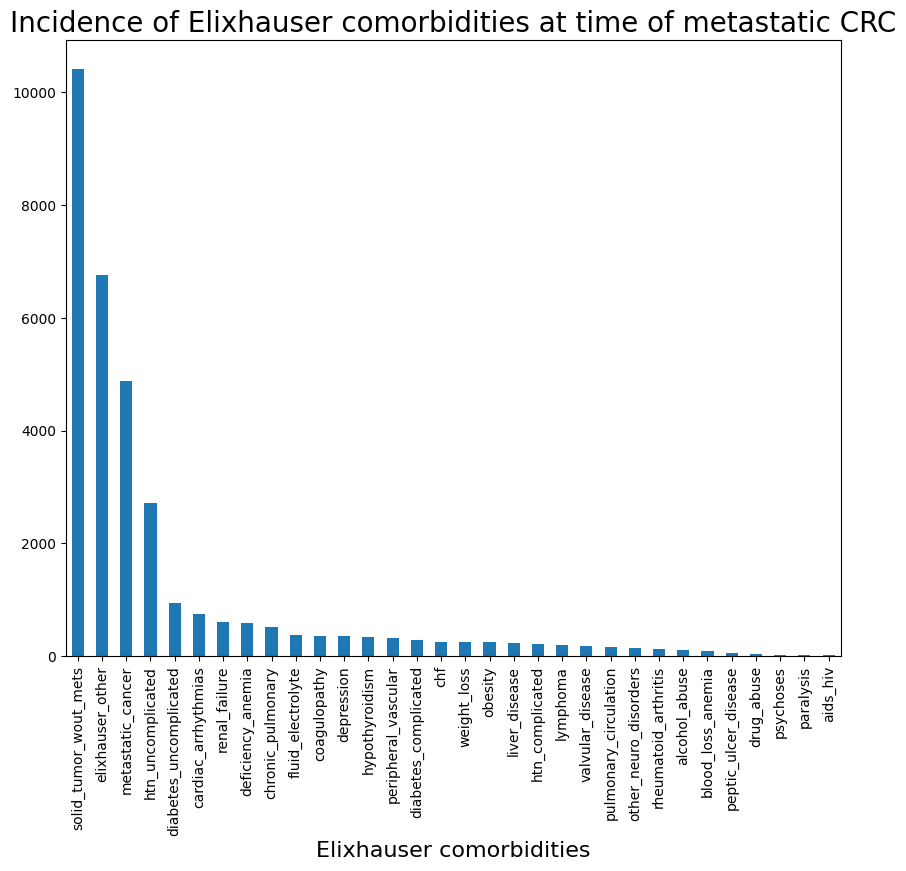

In [564]:
%matplotlib inline
diagnosis_elixhauser.iloc[:, 1:33].sum(axis = 0).sort_values(ascending = False).plot(kind = 'bar', figsize = (10,8))
plt.xlabel('Elixhauser comorbidities', fontsize = 16)
plt.title('Incidence of Elixhauser comorbidities at time of metastatic CRC', fontsize = 20)

Text(0.5, 1.0, 'Incidence of Elixhauser comorbidities at time of metastatic CRC')

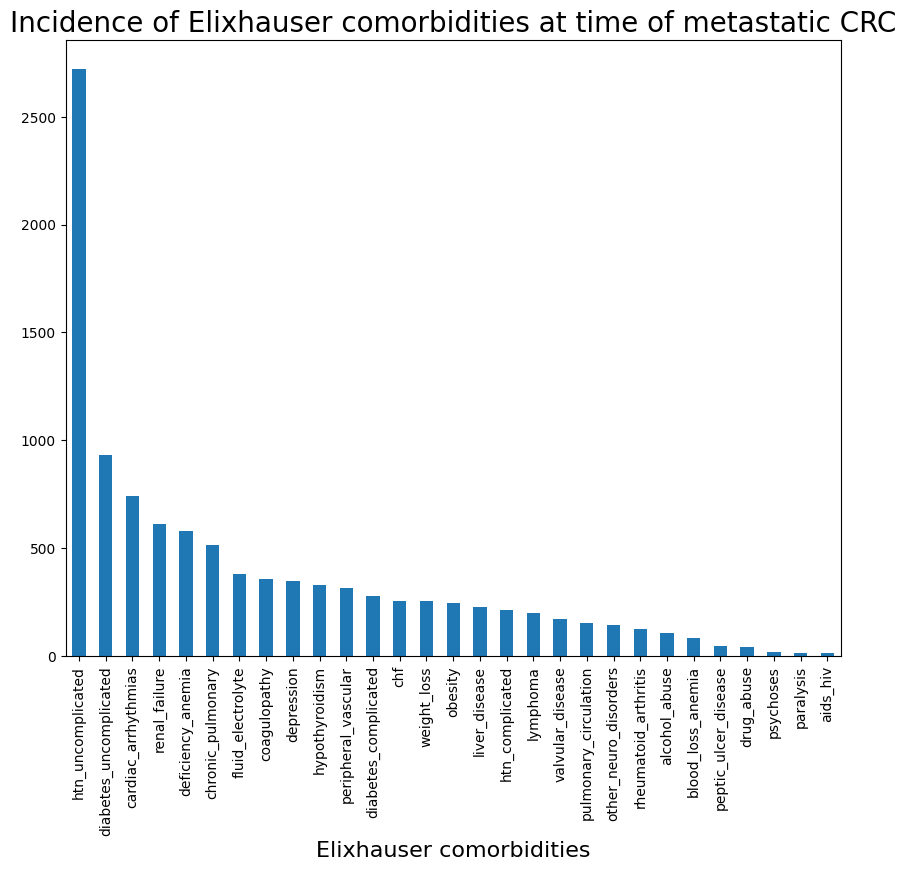

In [565]:
# Same plot as above but excluding tumor and mets.
%matplotlib inline
diagnosis_elixhauser.iloc[:, 1:33].sum(axis = 0).sort_values(ascending = False).tail(29).plot(kind = 'bar', figsize = (10,8))
plt.xlabel('Elixhauser comorbidities', fontsize = 16)
plt.title('Incidence of Elixhauser comorbidities at time of metastatic CRC', fontsize = 20)

In [566]:
# Append missing training IDs.
diagnosis_elixhauser = (
    diagnosis_elixhauser
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(diagnosis_elixhauser['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [567]:
row_ID(diagnosis_elixhauser)

(15141, 15141)

In [568]:
diagnosis_elixhauser.sample(5)

,PatientID,chf,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,htn_uncomplicated,htn_complicated,paralysis,other_neuro_disorders,...,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemia,alcohol_abuse,drug_abuse,psychoses,depression,elixhauser_other,icd_count
5583,F7FDE7599EFBA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
8994,FCE6A9DF3486E,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
10551,FF24C9F25663A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3341,F3E5D5DFBB08F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2852,F427773AB4244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Other cancer 

##### ICD-9 Cancer codes 

In [569]:
# Select all ICD-9 cancer codes between 140-209.
# Exclude benign neoplasms: 210-229, carcinoma in site: 230-234, and neoplasms of uncertain behavior or nature: 235-239.
cancer_9 = (
    diagnosis_elix_9[diagnosis_elix_9['DiagnosisCode'].str.startswith(
        ('14','15', '16', '17', '18', '19', '20'))]
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [570]:
row_ID(cancer_9)

(6511, 4440)

**Remove the following ICD-9 codes representing prostate cancer, metastasis, ill-defined neoplasms, and benign neoplasms of skin (BCC and SCC):**
* **173 - Other and unspecified malignant neoplasm of skin**
* **185 - Malignant neoplasm of the prostate**
* **196 - Secondary and unspecified malignant neoplasm of lymph nodes**
* **197 - Secondary malignant neoplasm of respiratory and digestive systems**
* **198 - Secondary malignant neoplasm of other specified sites** 
* **199 - Malignant neoplasm without specification of site**

In [571]:
# Count ICD-9 neoplasm codes that represent breast cancer or its associated metastases.
(
    cancer_9[cancer_9['diagnosis_code'].str.match('173|'
                                                  '185|'
                                                  '19([6789])')]
    .DiagnosisCode
    .value_counts(normalize = True)
    .head(10)
)

185       0.714509
198.5     0.187489
196.6     0.009731
199.1     0.009383
197.0     0.007993
197.7     0.005734
196.8     0.005213
196.9     0.005039
198.89    0.004692
197.6     0.004170
Name: DiagnosisCode, dtype: float64

In [572]:
# Dataframe of ICD-9 neoplasm codes that exclude colorectal cancer, metastasis, or benign neoplasms.
other_cancer_9 = (
    cancer_9[~cancer_9['diagnosis_code'].str.match('173|'
                                                   '185|'
                                                   '19([6789])')]
)

In [573]:
other_cancer_9.DiagnosisCode.value_counts(normalize = True).head(10)

188.9     0.071429
189.0     0.058201
153.9     0.050265
204.10    0.041005
202.80    0.037037
162.3     0.037037
162.9     0.031746
172.9     0.031746
172.5     0.022487
154.1     0.018519
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-9 codes at time of diagnosis that aren't prostate cancer, metastasis, or benign neoplasm:**
* **188.9 - Malignant neoplasm of bladder, part unspecified**
* **189.0 - Malignant neoplasm of kidney and other and unspecified urinary organs**
* **153.9 - Malignant neoplasm of colon, unspecified site**
* **204.10 - Chronic lymphoid leukemia, without mention of having achieved remission**
* **202.80 - Other malignant lymphomas**
* **162.3 - Malignant neoplasm of upper lobe, bronchus or lung**
* **162.9 - Malignant neoplasm of bronchus and lung, unspecified**
* **172.9 - Melanoma of skin, site unspecified**
* **172.5 - Malignant melanoma of skin of trunk, except scrotum**
* **154.1 - Malignant neoplasm of rectum**

In [574]:
other_cancer_9.DiagnosisCode.str[0:3].value_counts(normalize = True).head(10)

153    0.123016
188    0.112434
172    0.109788
202    0.103175
162    0.091270
189    0.063492
204    0.052910
200    0.046296
154    0.035714
209    0.033069
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-9 family codes at time of diagnosis that aren't prostate cancer, metastasis, or benign neoplasm:**
* **153 - Malignant neoplasm of colon**
* **188 - Malignant neoplasm of bladder**
* **172 - Malignant melanoma of skin**
* **202 - Other malignant neoplasms of lymphoid and histiocytic tissue**
* **162 - Malignant neoplasm of trachea bronchus and lung**
* **189 - Malignant neoplasm of kidney and other and unspecified urinary organs**
* **204 - Lymphoid leukemia**
* **200 - Lymphosarcoma and reticulosarcoma and other specified malignant tumors of lymphatic tissue**
* **154 - Malignant neoplasm of rectum rectosigmoid junction and anus**
* **209 - Neuroendocrine tumors**

In [575]:
other_cancer_9.loc[:,'other_cancer_9'] = 1

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [576]:
other_cancer_9 = (
    other_cancer_9
    .drop_duplicates(subset = 'PatientID', keep = 'first')
    .filter(items = ['PatientID', 'other_cancer_9'])
)

In [577]:
row_ID(other_cancer_9)

(588, 588)

In [578]:
other_cancer_9 = (
    other_cancer_9
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(other_cancer_9['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [579]:
row_ID(other_cancer_9)

(15141, 15141)

##### ICD-10 Cancer codes

In [580]:
# Select all ICD-10 codes between C00-D49 
# Exclude in situ neoplasms: D00-D09, benign neoplasms: D10-D36, benign neuroendocrine tumor: D3A, and neoplasms of unspecified behavior: D37 and D49
cancer_10 = (
    diagnosis_elix_10[diagnosis_elix_10['DiagnosisCode'].str.startswith(
        ('C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'D38', 'D39', 'D4'))]
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [581]:
row_ID(cancer_10)

(12469, 7372)

**Remove the following ICD-10 codes which capture breast cancer, metastasis, and benign skin neoplasms(eg., BCC and SCC).**
* **C61 - Malignant neoplasm of prostate** 
* **C44 - Other and unspecified malignant neoplasm of skin**
* **C77 - Secondary and unspecified malignant neoplasm of lymph nodes**
* **C78 - Secondary malignant neoplasm of respiratory and digestive organs**
* **C79 - Secondary malignant neoplasm of other and unspecified sites**
* **C80 - Malignant neoplasm without specification of site**
* **D47.2 - Monoclonal gammopathy**
* **D48 - Neoplasm of uncertain behavior of other and unspecified sites**
* **D49 - Neoplasms of unspecified behavior** 

In [582]:
# Count of top 10 ICD-10 codes that represent prostate cancer or metastasis. 
(
    cancer_10[cancer_10['diagnosis_code'].str.match('C61|'
                                                    'C44|'
                                                    'C7[789]|'
                                                    'C80|'
                                                    'D4(72|[89])')]
    .DiagnosisCode
    .value_counts(normalize = True)
    .head(10)
)

C61       0.576450
C79.51    0.269351
C77.5     0.014805
C77.2     0.011255
C77.9     0.010476
C80.1     0.009004
C78.7     0.008571
C79.9     0.007446
C77.8     0.005801
C78.01    0.005628
Name: DiagnosisCode, dtype: float64

In [583]:
# Dataframe of ICD-10 neoplasm codes that exclude prostate cancer, metastasis, or benign neoplasms.
other_cancer_10 = (
    cancer_10[~cancer_10['diagnosis_code'].str.match('C61|'
                                                     'C44|'
                                                     'C7[789]|'
                                                     'C80|'
                                                     'D4(72|[89])')]
)

In [584]:
other_cancer_10.DiagnosisCode.value_counts(normalize = True).head(10)

C67.9     0.080522
C91.10    0.031556
C18.9     0.029380
C20       0.020675
C67.8     0.020675
C90.00    0.019587
C64.2     0.019587
C34.12    0.018498
C34.90    0.018498
C34.11    0.017410
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-10 codes at time of diagnosis that aren't breast cancer, metastasis, or benign neoplasm:**
* **C67.9 - Malignant neoplasm of bladder, unspecified**
* **C91.10 - Chronic lymphocytic leukemia of B-cell type not having achieved remission**
* **C18.9 - Malignant neoplasm of colon, unspecified**
* **C20 - Malignant neoplasm of rectum**
* **C67.8 - Malignant neoplasm of overlapping sites of bladder**
* **C90.00 - Multiple myeloma not having achieved remission**
* **C64.2 - Malignant neoplasm of left kidney, except renal pelvis**
* **C34.12 - Malignant neoplasm of upper lobe, left bronchus or lung**
* **C34.90 - Malignant neoplasm of unspecified part of unspecified bronchus or lung**
* **C34.11 - Malignant neoplasm of upper lobe, right bronchus or lung**

In [585]:
other_cancer_10.DiagnosisCode.str[0:3].value_counts(normalize = True).head(10)

C67    0.141458
C34    0.105550
C18    0.058760
C91    0.048966
C83    0.046790
C43    0.046790
C64    0.044614
C85    0.040261
C82    0.029380
C7A    0.028292
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-10 family codes at time of diagnosis that aren't colorectal cancer, metastasis, or benign neoplasm:**
* **C67 - Malignant neoplasm of bladder**
* **C34 - Malignant neoplasm of bronchus and lung**
* **C18 - Malignant neoplasm of colon**
* **C91 - Lymphoid leukemia**
* **C83 - Non-follicular lymphoma**
* **C43 - Malignant melanoma of skin**
* **C64 - Malignant neoplasm of kidney, except renal pelvis**
* **C85 - Other specified and unspecified types of non-Hodgkin lymphoma**
* **C82 - Follicular lymphoma**
* **C7A - Malignant neuroendocrine tumors**

In [586]:
other_cancer_10.loc[:,'other_cancer_10'] = 1

In [587]:
# Drop duplicates.
other_cancer_10 = (
    other_cancer_10
    .drop_duplicates(subset = 'PatientID', keep = 'first')
    .filter(items = ['PatientID', 'other_cancer_10'])
)

In [588]:
row_ID(other_cancer_10)

(681, 681)

In [589]:
# Append missing training IDs.
other_cancer_10 = (
    other_cancer_10
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(other_cancer_10['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [590]:
row_ID(other_cancer_10)

(15141, 15141)

In [591]:
other_cancer = pd.merge(other_cancer_9, other_cancer_10, on = 'PatientID')

In [592]:
# Combine other_cancer_9 and other_cancer_19; replace values equal to 2 with 1. 
other_cancer = (
    other_cancer
    .assign(other_cancer = other_cancer['other_cancer_9'] + other_cancer['other_cancer_10'])
    .filter(items = ['PatientID', 'other_cancer'])
    .replace(2, 1)
)

In [593]:
row_ID(other_cancer)

(15141, 15141)

In [594]:
# Percentage of patients with a cancer other than prostate or mets. 
len(other_cancer[other_cancer['other_cancer'] == 1])/len(other_cancer)

0.07766990291262135

#### Sites of metastases

##### ICD-9 sites of metastases

In [595]:
# Create dataframe contianing patients with ICD-9 codes within -90 to +30 days from metastatic diagnosis and remove duplicate codes
diagnosis_mets_9 = (
    diagnosis
    .query('diagnosis_date_diff >= -90 and diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = ['PatientID', 'DiagnosisCode'], keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

**Sites of metastasis will be grouped into the following categories according to ICD-9 codes:**
* **Thorax - 197.0, 197.1, 197.2, and 197.3**
* **Peritoneum - 197.6**
* **Liver - 197.7**
* **Other GI - 197.4 and 197.8**
* **CNS - 198.3 and 198.4**
* **Bone - 198.5**
* **Lymph -- 196**
* **Kidney, bladder -- 198.0 and 198.1**
* **Other - 198.2, 198.6, 198.7, and 198.8**

In [596]:
diagnosis_mets_9['thorax_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('197[0123]'), 1, 0)

In [597]:
diagnosis_mets_9['peritoneum_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('1976'), 1, 0)

In [598]:
diagnosis_mets_9['liver_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('1977'), 1, 0)

In [599]:
diagnosis_mets_9['other_gi_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('197[48]'), 1, 0)

In [600]:
diagnosis_mets_9['cns_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('198[34]'), 1, 0)

In [601]:
diagnosis_mets_9['bone_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('1985'), 1, 0)

In [602]:
diagnosis_mets_9['lymph_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('196'), 1, 0)

In [603]:
diagnosis_mets_9['kidney_bladder_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('198[01]'), 1, 0)

In [604]:
diagnosis_mets_9['other_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('198[2678]'), 1, 0)

In [605]:
# Collapse columns and sum.
diagnosis_mets_9 = (
    diagnosis_mets_9
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

##### ICD-10 sites of metastases

In [606]:
# Create dataframe contianing patients with ICD-10 codes within -90 to +30 days from advanced diagnosis and remove duplicate codes.
diagnosis_mets_10 = (
    diagnosis
    .query('diagnosis_date_diff >= -90 and diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = ['PatientID', 'DiagnosisCode'], keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

**Sites of metastasis will be grouped into the following categories according to ICD-10 codes:**
* **Thorax - C78.0, C78.1, C78.2, and C78.3**
* **Peritoneum - C78.6**
* **Liver - C78.7**
* **Other GI - C78.4 and C78.8**
* **CNS - C79.3 and C79.4**
* **Bone - C79.5**
* **Lymph -- C77**
* **Kidney, bladder -- C79.0 and 79.1**
* **Other - C79.2, C79.6, C79.7, C79.8, and C79.9**

In [607]:
diagnosis_mets_10['thorax_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C78[0123]'), 1, 0)

In [608]:
diagnosis_mets_10['peritoneum_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C786'), 1, 0)

In [609]:
diagnosis_mets_10['liver_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C787'), 1, 0)

In [610]:
diagnosis_mets_10['other_gi_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C78[48]'), 1, 0)

In [611]:
diagnosis_mets_10['cns_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C79[34]'), 1, 0)

In [612]:
diagnosis_mets_10['bone_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C795'), 1, 0)

In [613]:
diagnosis_mets_10['lymph_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C77'), 1, 0)

In [614]:
diagnosis_mets_10['kidney_bladder_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C79[01]'), 1, 0)

In [615]:
diagnosis_mets_10['other_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C79[26789]'), 1, 0)

In [616]:
# Collapse columns and sum. 
diagnosis_mets_10 = (
    diagnosis_mets_10
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

In [617]:
# Merge ICD-9 and ICD-10 mets tables; collapse and sum. 
mets_wide = (
    pd.concat([diagnosis_mets_9, diagnosis_mets_10])
    .groupby('PatientID').sum()
)

In [618]:
# All values >1 replaced by 1. 
mets_wide = (
    mets_wide.mask(mets_wide > 1, 1)
    .reset_index()
)

In [619]:
# Append missing training IDs.
mets_wide = (
    mets_wide.append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(mets_wide['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [620]:
row_ID(mets_wide)

(15141, 15141)

In [621]:
# Percentage with mets by site of location at time of metastatic diagnosis
(mets_wide.iloc[:, 1:].sum()/len(mets_wide)).sort_values(ascending = False)

bone_met              0.264117
lymph_met             0.034674
thorax_met            0.012218
other_met             0.010832
liver_met             0.007397
peritoneum_met        0.004887
kidney_bladder_met    0.003104
cns_met               0.002246
other_gi_met          0.000198
dtype: float64

In [622]:
# Total percentage of patiens with ICD code indicating mets at time of metastatic diagnosis. 
len(mets_wide[mets_wide.eq(1).any(1)])/len(mets_wide)

0.2968760319661845

In [623]:
mets_wide.sample(5)

,PatientID,thorax_met,peritoneum_met,liver_met,other_gi_met,cns_met,bone_met,lymph_met,kidney_bladder_met,other_met
2264,F8A21980ED430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7780,FE05536B18B2B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
412,F0656CD0D71B4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5817,F81617B440302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1090,F2108F7CA7CE8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Merge

In [624]:
diagnosis_wide = pd.merge(diagnosis_elixhauser, other_cancer, on = 'PatientID')

In [625]:
diagnosis_wide = pd.merge(diagnosis_wide, mets_wide, on = 'PatientID')

In [626]:
row_ID(diagnosis_wide)

(15141, 15141)

In [627]:
list(diagnosis_wide.columns)

['PatientID',
 'chf',
 'cardiac_arrhythmias',
 'valvular_disease',
 'pulmonary_circulation',
 'peripheral_vascular',
 'htn_uncomplicated',
 'htn_complicated',
 'paralysis',
 'other_neuro_disorders',
 'chronic_pulmonary',
 'diabetes_uncomplicated',
 'diabetes_complicated',
 'hypothyroidism',
 'renal_failure',
 'liver_disease',
 'peptic_ulcer_disease',
 'aids_hiv',
 'lymphoma',
 'metastatic_cancer',
 'solid_tumor_wout_mets',
 'rheumatoid_arthritis',
 'coagulopathy',
 'obesity',
 'weight_loss',
 'fluid_electrolyte',
 'blood_loss_anemia',
 'deficiency_anemia',
 'alcohol_abuse',
 'drug_abuse',
 'psychoses',
 'depression',
 'elixhauser_other',
 'icd_count',
 'other_cancer',
 'thorax_met',
 'peritoneum_met',
 'liver_met',
 'other_gi_met',
 'cns_met',
 'bone_met',
 'lymph_met',
 'kidney_bladder_met',
 'other_met']

In [628]:
%whos DataFrame

Variable                 Type         Data/Info
-----------------------------------------------
biomarker_wide           DataFrame               PatientID brca<...>n[15141 rows x 2 columns]
cancer_10                DataFrame                PatientID Dia<...>n[12469 rows x 3 columns]
cancer_9                 DataFrame                PatientID Dia<...>\n[6511 rows x 3 columns]
demographics             DataFrame               PatientID Gend<...>n[15141 rows x 6 columns]
diagnosis                DataFrame                PatientID Dia<...>[480268 rows x 8 columns]
diagnosis_elix_10        DataFrame                PatientID Dia<...>[59867 rows x 35 columns]
diagnosis_elix_10_wide   DataFrame              PatientID  chf <...>n[8172 rows x 33 columns]
diagnosis_elix_9         DataFrame                PatientID Dia<...>[28807 rows x 35 columns]
diagnosis_elix_9_wide    DataFrame              PatientID  chf <...>n[5230 rows x 33 columns]
diagnosis_elixhauser     DataFrame               PatientID

In [629]:
# Keep biomarker_wide, demographics, diagnosis_wide, ecog_diagnosis_wide, enhanced_met, insurance_wide, 
# lab_wide, med_admin_wide, mortality, and weight_wide
del cancer_10
del cancer_9
del diagnosis
del diagnosis_elix_10
del diagnosis_elix_10_wide
del diagnosis_elix_9
del diagnosis_elix_9_wide
del diagnosis_elixhauser
del diagnosis_mets_10
del diagnosis_mets_9
del mets_wide
del other_cancer
del other_cancer_10
del other_cancer_9

### 11. Prior treatments 

#### Surgery or radiation 

In [630]:
prim_treat = pd.read_csv('Enhanced_MetPC_PrimaryTreatment.csv')

In [631]:
prim_treat = prim_treat[prim_treat['PatientID'].isin(train_IDs)]

In [632]:
row_ID(prim_treat)

(6552, 6552)

In [633]:
prim_treat.sample(5)

,PatientID,TreatmentType,TreatmentDate
396,F48DDF5E48F3E,Prostatectomy / Surgery,1992-01-01
2227,F5523FC908D10,Prostatectomy / Surgery,2000-01-01
1840,F6B189868DD71,Radiation Therapy (Including Brachytherapy and...,2007-01-01
5644,FEDCD5938403D,Prostatectomy / Surgery,2013-01-01
3415,FEB992F0CB6A4,Prostatectomy / Surgery,2010-12-02


In [634]:
prim_treat.TreatmentType.value_counts(normalize = True, dropna = False)

Prostatectomy / Surgery                                              0.495421
Radiation Therapy (Including Brachytherapy and Radioactive Seeds)    0.482448
Cryotherapy                                                          0.020604
High Intensity Focused Ultrasound (HIFU)                             0.001526
Name: TreatmentType, dtype: float64

In [635]:
prim_treat.loc[:, 'TreatmentDate'] = pd.to_datetime(prim_treat['TreatmentDate'])

In [636]:
prim_treat = pd.merge(prim_treat, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [637]:
prim_treat.query('TreatmentDate > met_date')

,PatientID,TreatmentType,TreatmentDate,met_date
1888,F44C43E6E39DF,Radiation Therapy (Including Brachytherapy and...,2014-02-01,2014-01-21
1927,F1D3075251CD9,Radiation Therapy (Including Brachytherapy and...,2022-06-28,2022-06-02
2000,FDB8D42BDDE06,Radiation Therapy (Including Brachytherapy and...,2014-07-15,2014-03-07
3113,F71D11C917212,Radiation Therapy (Including Brachytherapy and...,2016-12-28,2016-06-01
3986,F3A1D7A611FEA,Radiation Therapy (Including Brachytherapy and...,2018-04-01,2017-12-14
5178,F531D923DA9CC,Radiation Therapy (Including Brachytherapy and...,2019-06-05,2019-05-01
5826,F67C10C79A342,Radiation Therapy (Including Brachytherapy and...,2021-10-19,2021-09-20
5935,F9C37ECB924F2,Prostatectomy / Surgery,2021-10-29,2021-09-28
6042,FD3E314C35625,Radiation Therapy (Including Brachytherapy and...,2020-05-20,2020-03-03
6489,F497E0B4BE962,Radiation Therapy (Including Brachytherapy and...,2021-12-13,2021-10-26


In [638]:
conditions = [
    (prim_treat['TreatmentType'] == 'Prostatectomy / Surgery'),
    (prim_treat['TreatmentType'] == 'Radiation Therapy (Including Brachytherapy and Radioactive Seeds)')]

choices = ['prostatectomy', 'radiation']

prim_treat.loc[:, 'prim_treatment'] = np.select(conditions, choices, default = 'other')

In [639]:
prim_treat.prim_treatment.value_counts(normalize = True, dropna = False)

prostatectomy    0.495421
radiation        0.482448
other            0.022131
Name: prim_treatment, dtype: float64

In [640]:
prim_treat = (
    prim_treat
    .assign(treat_diff = (prim_treat['TreatmentDate'] - prim_treat['met_date']).dt.days)
)

In [641]:
prim_treat['treat_diff'].describe()

count     6421.000000
mean     -3322.379847
std       2422.444571
min     -18993.000000
25%      -4821.000000
50%      -2825.000000
75%      -1385.000000
max        210.000000
Name: treat_diff, dtype: float64

In [642]:
prim_treat = prim_treat[['PatientID', 'prim_treatment']]

In [643]:
# Append missing training IDs.
prim_treat_wide = (
    prim_treat.append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(prim_treat['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna('unknown')
)

#### ADT 

In [644]:
adt = pd.read_csv('Enhanced_MetPC_ADT.csv')

In [645]:
adt = adt[adt['PatientID'].isin(train_IDs)]

In [646]:
row_ID(adt)

(16397, 14629)

In [647]:
adt.sample(5)

,PatientID,TreatmentSetting,StartDate,EndDate,TreatmentStatus
16645,F1A0FD95E6C73,Advanced,2013-12-18,NaN,Continuing
2370,F0D891528B359,Advanced,2018-06-01,NaN,Continuing
12216,F367398E7385F,Advanced,NaN,NaN,Continuing
8461,F1DFA5979081D,Advanced,2021-08-18,NaN,Continuing
15397,F09BC17E14C7F,Advanced,2022-02-17,NaN,Continuing


In [648]:
adt.TreatmentSetting.value_counts(dropna = False)

Advanced    14299
Curative     2098
Name: TreatmentSetting, dtype: int64

In [649]:
adt.loc[:, 'StartDate'] = pd.to_datetime(adt['StartDate'])

In [650]:
adt = pd.merge(adt, enhanced_met[['PatientID', 'met_date']], on = 'PatientID', how = 'left')

In [651]:
adt.query('StartDate >= met_date').TreatmentSetting.value_counts()

Advanced    8696
Curative      20
Name: TreatmentSetting, dtype: int64

In [652]:
adt.query('StartDate < met_date').TreatmentSetting.value_counts()

Advanced    4465
Curative    1996
Name: TreatmentSetting, dtype: int64

In [653]:
adt = (
    adt
    .assign(adt_diff = (adt['StartDate'] - adt['met_date']).dt.days)
)

In [654]:
adt['adt_diff'].describe()

count    15177.000000
mean      -673.433287
std       1386.593256
min     -10654.000000
25%       -858.000000
50%          3.000000
75%         27.000000
max       3376.000000
Name: adt_diff, dtype: float64

In [655]:
adt = adt.query('adt_diff < -90')

In [656]:
row_ID(adt)

(5692, 5037)

In [657]:
adt = adt.drop_duplicates(subset = ['PatientID'], keep = 'first')

In [658]:
row_ID(adt)

(5037, 5037)

In [659]:
adt.loc[:,'early_adt'] = 1

In [660]:
adt = adt[['PatientID', 'early_adt']]

In [661]:
# Append missing training IDs.
adt_wide = (
    adt.append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(adt['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [662]:
row_ID(adt_wide)

(15141, 15141)

#### Merge

In [663]:
treat_wide = pd.merge(prim_treat_wide, adt_wide, on = 'PatientID')

In [664]:
row_ID(treat_wide)

(15141, 15141)

In [665]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
adt                   DataFrame               PatientID  ear<...>\n[5037 rows x 2 columns]
adt_wide              DataFrame               PatientID  ear<...>n[15141 rows x 2 columns]
biomarker_wide        DataFrame               PatientID brca<...>n[15141 rows x 2 columns]
demographics          DataFrame               PatientID Gend<...>n[15141 rows x 6 columns]
diagnosis_wide        DataFrame               PatientID  chf<...>[15141 rows x 44 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[15141 rows x 2 columns]
enhanced_met          DataFrame               PatientID diag<...>[15141 rows x 18 columns]
insurance_wide        DataFrame               PatientID  med<...>n[15141 rows x 9 columns]
lab_wide              DataFrame               PatientID  alb<...>15141 rows x 135 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[15141 rows x 13 columns]


In [666]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_met, mortality, 
# lab_wide, treat_wide, and weight_wide
del adt
del adt_wide
del prim_treat
del prim_treat_wide

## Part 3: File merge

In [667]:
enhanced_met = enhanced_met.drop(columns = ['diagnosis_date', 'met_date', 'met_year_cat', 'CRPCDate'])

In [668]:
train_full = pd.merge(demographics, enhanced_met, on = 'PatientID')

In [669]:
train_full = pd.merge(train_full, mortality, on = 'PatientID')

In [670]:
train_full = pd.merge(train_full, med_admin_wide, on = 'PatientID')

In [671]:
train_full = pd.merge(train_full, biomarker_wide, on = 'PatientID')

In [672]:
train_full = pd.merge(train_full, insurance_wide, on = 'PatientID')

In [673]:
train_full = pd.merge(train_full, ecog_diagnosis_wide, on = 'PatientID')

In [674]:
train_full = pd.merge(train_full, weight_wide, on = 'PatientID')

In [675]:
train_full = pd.merge(train_full, lab_wide, on = 'PatientID')

In [676]:
train_full = pd.merge(train_full, diagnosis_wide, on = 'PatientID')

In [677]:
train_full = pd.merge(train_full, treat_wide, on = 'PatientID')

In [678]:
row_ID(train_full)

(15141, 15141)

In [679]:
len(train_full.columns)

228

In [680]:
list(train_full.columns)

['PatientID',
 'Gender',
 'race',
 'ethnicity',
 'age',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'PSADiagnosis',
 'PSAMetDiagnosis',
 'stage',
 'met_year',
 'delta_met_diagnosis',
 'crpc',
 'crpc_time',
 'psa_diag_na',
 'psa_met_na',
 'death_status',
 'timerisk_activity',
 'steroid_diag',
 'opioid_PO_diag',
 'nonopioid_PO_diag',
 'pain_IV_diag',
 'ac_diag',
 'antiinfective_IV_diag',
 'antiinfective_diag',
 'antihyperglycemic_diag',
 'ppi_diag',
 'antidepressant_diag',
 'bta_diag',
 'thyroid_diag',
 'brca_status',
 'medicare',
 'medicaid',
 'medicare_medicaid',
 'commercial',
 'patient_assistance',
 'other_govt',
 'self_pay',
 'other',
 'ecog_diagnosis',
 'weight_diag',
 'bmi_diag',
 'bmi_diag_na',
 'weight_pct_change',
 'weight_pct_na',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potass

In [681]:
train_full.to_csv('train_full.csv', index = False, header = True)